In [1]:
import numpy as np
import time
import torchaudio
import torch
from functools import reduce
import scipy

import naplib as nl
from auditory_cortex.datasets import BaselineDataset, DNNDataset
from auditory_cortex.computational_models.encoding import TRF, GpuTRF
from auditory_cortex.analyses import STRFCorrelations, Correlations
from auditory_cortex import utils
from auditory_cortex.io_utils import io
from auditory_cortex.plotters.correlation_plotter import RegPlotter

import matplotlib.pylab as plt
import matplotlib as mpl
%matplotlib inline

INFO:fairseq.tasks.text_to_speech:Please install tensorboardX: pip install tensorboardX
DEBUG:matplotlib.pyplot:Loaded backend agg version unknown.
/home/ahmedb/projects/Wav2Letter/deepspeech.pytorch/deepspeech_pytorch/loader/data_loader.py:17: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [18]:
from auditory_cortex import opt_inputs_dir, results_dir, cache_dir
results_dir

'/depot/jgmakin/data/auditory_cortex/results/'

In [4]:
trials = np.arange(15)

In [10]:
np.random.shuffle(trials)
trials

array([12,  4,  7, 14,  0,  2,  6, 13,  9,  5,  8, 11,  3,  1, 10])

In [15]:
from auditory_cortex.neural_data.neural_meta_data import NeuralMetaData
metadata = NeuralMetaData()
sessions = metadata.get_all_available_sessions()

all_sessions = np.sort(sessions)

In [18]:
np.where(all_sessions=='180731')

(array([13]),)

In [17]:
sig_sessions = np.array([
            '200205', '191121', '191210', # non-primary sessions 27/35 channels...
            '200206', '191113', '180814', '200213', '191206', '191125', '180731',
            '200207', '180807',      # primary sessions 195/227 channels...
            ])
session_ids = []
for sess in sig_sessions:
	sess_id = np.where(all_sessions==sess)[0]
	# print(sess_id)
	session_ids.append(sess_id)
session_ids = np.sort(np.concatenate(session_ids))
session_ids

array([13, 14, 17, 24, 26, 27, 28, 30, 33, 34, 35, 37])

In [12]:
session_ids

array([  0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11])

#### resolving error in TRF fitting...

In [2]:
session = 180413
bin_width = 50
model_name = 'wav2letter_modified'
layer_ID = 2
mVocs=False
shuffled=False

LPF = False
LPF_analysis_bw = 20

lags = [300]
tmin = 0
num_workers=1
num_folds=3
use_nonlinearity=False
test_trial=None

In [3]:
dataset = DNNDataset(
	session, bin_width, model_name, layer_ID, mVocs=mVocs,
	shuffled=shuffled,
	LPF=LPF, LPF_analysis_bw=LPF_analysis_bw
	)
trf_obj = TRF(model_name, dataset)

180413: creating DNNDataset for timit data..
DNNDataset: Loading data for session-180413 at bin_width-50ms.
DataLoader: Extracting spikes for session-180413...
NeuralData:  Creating object for session: 180413 ... Done.
NeuralData: Reading neural spikes for 180413. 
Reading raw features from /scratch/gilbreth/ahmedb/cache/wav2letter_modified/wav2letter_modified_raw_features.pkl
Resamping ANN features at bin-width: 50
TRF object created for 'wav2letter_modified' model.


In [42]:
dataset.data_cache.keys()

dict_keys(['features', 'spikes'])

In [4]:

myset = [2,3,4,5,6, 7, 8, 9, 10]

for stim_id in myset:
	xx = dataset.data_cache['features'][stim_id]
	yy = dataset.data_cache['spikes'][stim_id]

	print(f"xx.shape: {xx.shape}, yy.shape: {yy.shape}")
	dur = dataset.dataloader.get_stim_dur(stim_id)
	print(f"duraion: {dur}, number of samples at sfreq: 20, equal= {dur*20}")

xx.shape: (46, 250), yy.shape: (46, 16)
duraion: 2.2528125, number of samples at sfreq: 20, equal= 45.056250000000006
xx.shape: (52, 250), yy.shape: (52, 16)
duraion: 2.56, number of samples at sfreq: 20, equal= 51.2
xx.shape: (51, 250), yy.shape: (51, 16)
duraion: 2.521625, number of samples at sfreq: 20, equal= 50.4325
xx.shape: (30, 250), yy.shape: (30, 16)
duraion: 1.4976250000000002, number of samples at sfreq: 20, equal= 29.952500000000004
xx.shape: (42, 250), yy.shape: (42, 16)
duraion: 2.08, number of samples at sfreq: 20, equal= 41.6
xx.shape: (50, 250), yy.shape: (50, 16)
duraion: 2.4768125, number of samples at sfreq: 20, equal= 49.536249999999995
xx.shape: (47, 250), yy.shape: (47, 16)
duraion: 2.329625, number of samples at sfreq: 20, equal= 46.5925
xx.shape: (43, 250), yy.shape: (43, 16)
duraion: 2.13125, number of samples at sfreq: 20, equal= 42.625
xx.shape: (46, 250), yy.shape: (46, 16)
duraion: 2.29125, number of samples at sfreq: 20, equal= 45.824999999999996


duraion: 1.1049375, number of samples at sfreq: 20, equal= 22.09875


In [34]:
tmax = 300
mapping_set = None
tmin = tmin/1000
tmax = tmax/1000
sfreq = 1000/trf_obj.dataset_obj.get_bin_width()
num_channels = trf_obj.dataset_obj.num_channels

# Deprecated...
if mapping_set is None:
	mapping_set = trf_obj.dataset_obj.training_sent_ids
	np.random.shuffle(mapping_set)
# mapping_set = self.dataset_obj.get_training_stim_ids()
# lmbdas = np.logspace(-12, 7, 20)
# lmbdas = np.logspace(-2, 5, 8)
# lmbdas = np.logspace(-2, 10, 13)
lmbdas = np.logspace(-5, 10, 16)
lmbda_score = np.zeros(((len(lmbdas), num_channels)))
size_of_chunk = int(len(mapping_set) / num_folds)

r = 0
print(f"\n For fold={r}: ")
if r<(num_folds-1):
	val_set = mapping_set[r*size_of_chunk:(r+1)*size_of_chunk]
else:
	val_set = mapping_set[r*size_of_chunk:]
train_set = mapping_set[np.isin(mapping_set, val_set, invert=True)]

train_x, train_y = trf_obj.dataset_obj.get_data(stim_ids=train_set)
val_x, val_y = trf_obj.dataset_obj.get_data(stim_ids=val_set)


 For fold=0: 


In [38]:
train_set[:5]

array([140, 194, 493, 259, 342])

In [40]:
sett = train_set[:5]
print(f"Training set: {sett}")
val_xx, val_yy = trf_obj.dataset_obj.get_data(stim_ids=sett)
x_samples = 0
y_samples = 0
for xx, yy in zip(val_xx, val_yy):
	print(f"xx.shape: {xx.shape}, yy.shape: {yy.shape}")
	x_samples += xx.shape[0]
	y_samples += yy.shape[0]
print(f"Number of samples of x: {x_samples}")
print(f"Number of samples of y: {y_samples}")

Training set: [140 194 493 259 342]
xx.shape: (40, 250), yy.shape: (46, 16)
xx.shape: (32, 250), yy.shape: (36, 16)
xx.shape: (34, 250), yy.shape: (40, 16)
xx.shape: (42, 250), yy.shape: (49, 16)
xx.shape: (44, 250), yy.shape: (50, 16)
Number of samples of x: 192
Number of samples of y: 221


In [35]:
x_samples = 0
y_samples = 0
for xx, yy in zip(train_x, train_y):
	x_samples += xx.shape[0]
	y_samples += yy.shape[0]
print(f"Number of samples of x: {x_samples}")
print(f"Number of samples of y: {y_samples}")

Number of samples of x: 11335
Number of samples of y: 13582


In [36]:
x_samples = 0
y_samples = 0
for xx, yy in zip(val_x, val_y):
	x_samples += xx.shape[0]
	y_samples += yy.shape[0]
print(f"Number of samples of x: {x_samples}")
print(f"Number of samples of y: {y_samples}")

Number of samples of x: 5649
Number of samples of y: 6769


In [13]:
train_x[1].shape

(42, 1024)

In [15]:
i = 0
lmbda = lmbdas[i]
lmbda_score = []

trf_model = GpuTRF(
		tmin, tmax, sfreq, alpha=lmbda,
		# n_jobs=1, show_progress=True
		)
# trf_model.fit(X=train_x, y=train_y)

# save validation score for lmbda..
# lmbda_score[i] += trf_model.score(X=val_x, y=val_y)

GpuTRF object created with alpha=1e-05, tmin=0.0, tmax=0.3, sfreq=20.0


In [16]:
X = train_x
y = train_y

In [19]:
trf_model.ndim_y_ = y[0].ndim
trf_model.X_feats_ = X[0].shape[-1]
trf_model.n_targets_ = y[0].shape[1]
trf_model.n_models = None

X_delayed, y_delayed = [], []
for xx, yy in zip(X, y):
	X_tmp, y_tmp = trf_model._delay_and_reshape(xx, yy)
	X_delayed.append(X_tmp)
	y_delayed.append(y_tmp)

In [20]:
X_delayed = np.concatenate(X_delayed, axis=0)
y_delayed = np.concatenate(y_delayed, axis=0)

In [21]:
X_delayed.shape

(11360, 7168)

In [22]:
y_delayed.shape

(13592, 16)

In [ ]:






if self.n_alphas == 1:
	self.model.fit(X_delayed, y_delayed)
else:
	for i in range(self.n_alphas):

In [ ]:
for i, lmbda in enumerate(lmbdas):

	# if use_nonlinearity:
	# 	estimator = PoissonRegressor(alpha=lmbda)
	# else:
	# 	estimator = Ridge(alpha=lmbda)

	# trf_model = nl.encoding.TRF(
	# 		tmin, tmax, sfreq, estimator=estimator,
	# 		n_jobs=num_workers, show_progress=True
	# 		)
	

In [ ]:


for r in range(num_folds):
	print(f"\n For fold={r}: ")
	if r<(num_folds-1):
		val_set = mapping_set[r*size_of_chunk:(r+1)*size_of_chunk]
	else:
		val_set = mapping_set[r*size_of_chunk:]
	train_set = mapping_set[np.isin(mapping_set, val_set, invert=True)]

	train_x, train_y = self.dataset_obj.get_data(stim_ids=train_set)
	val_x, val_y = self.dataset_obj.get_data(stim_ids=val_set)
	for i, lmbda in enumerate(lmbdas):

		# if use_nonlinearity:
		# 	estimator = PoissonRegressor(alpha=lmbda)
		# else:
		# 	estimator = Ridge(alpha=lmbda)
	
		# trf_model = nl.encoding.TRF(
		# 		tmin, tmax, sfreq, estimator=estimator,
		# 		n_jobs=num_workers, show_progress=True
		# 		)
		trf_model = GpuTRF(
			tmin, tmax, sfreq, alpha=lmbda,
			# n_jobs=1, show_progress=True
			)
		trf_model.fit(X=train_x, y=train_y)

		# save validation score for lmbda..
		lmbda_score[i] += trf_model.score(X=val_x, y=val_y)

lmbda_score /= num_folds
# avg_lmbda_score = np.mean(lmbda_score, axis=1)
max_lmbda_score = np.max(lmbda_score, axis=0)
opt_lmbda = lmbdas[np.argmax(lmbda_score, axis=0)]

In [6]:
lag = lags[0]
N_sents = 500
mapping_set = trf_obj.get_mapping_set_ids(N_sents=N_sents, mVocs=trf_obj.dataset_obj.mVocs)
print(f"\n Running for max lag={lag} ms")
score, opt_lmbda = trf_obj.cross_validated_fit(
	tmax=lag,
	tmin=tmin, 
	num_workers=num_workers,
	num_folds=num_folds,
	mapping_set=mapping_set,
	use_nonlinearity=use_nonlinearity
	)


 Running for max lag=300 ms

 For fold=0: 
GpuTRF object created with alpha=1e-05, tmin=0.0, tmax=0.3, sfreq=20.0


ValueError: Dimension k with different lengths in arrays

In [ ]:
corr, opt_lag, opt_lmbda, trf_model = trf_obj.grid_search_CV(
		lags=lags, tmin=tmin,
		num_workers=num_workers, num_folds=num_folds,
		use_nonlinearity=use_nonlinearity,
		test_trial=test_trial
	)

#### make predictions, using fitted models...

In [2]:
def read_betas(model_name, session, bin_width=50, shuffled=False, bias=False):
	betas = io.read_trf_parameters(model_name, session, bin_width, shuffled, verbose=False,
		bias=bias)
	return betas

In [2]:
from auditory_cortex.datasets import BaselineDataset, DNNDataset
session = 200206
bin_width = 50
model_name = 'whisper_base'
layer_ID = 2
mVocs=False
shuffled=False

LPF = False


In [3]:
dataset = DNNDataset(
                session, bin_width, model_name, layer_ID, mVocs=mVocs,
                shuffled=shuffled,
                LPF=LPF, 
                )

200206: creating DNNDataset for timit data..
DNNDataset: Loading data for session-200206 at bin_width-50ms.
DataLoader: Extracting spikes for session-200206...
NeuralData:  Creating object for session: 200206 ... Done.
NeuralData: Reading neural spikes for 200206. 
Reading raw features from /scratch/gilbreth/ahmedb/cache/whisper_base/whisper_base_raw_features.pkl
Resamping ANN features at bin-width: 50


In [4]:
trf_obj = TRF(model_name, dataset)

TRF object created for 'whisper_base' model.


In [7]:
# dataset = DNNDataset(
# 		session, bin_width, model_name, layer
# 		)
# trf_obj = TRF(model_name, dataset)
layer = layer_ID
sent_ids = [12]
saved_predictions = trf_obj.neural_prediction(
		model_name, session, layer, bin_width, sent_ids,
	)

Reading TRF parameters for whisper_base, session-200206,bin-width-50ms, shuffled-False, LPF-False, bias-False
Reading TRF parameters for whisper_base, session-200206,bin-width-50ms, shuffled-False, LPF-False, bias-True
GpuTRF object created with alpha=0.1, tmin=0, tmax=0.3, sfreq=20.0


In [9]:
saved_predictions

AttributeError: 'list' object has no attribute 'shape'

In [17]:
session = int(session)
weights = io.read_trf_parameters(
		model_name, session, bin_width, shuffled,
		verbose=False, bias=False,
	)[layer_ID]

biases = io.read_trf_parameters(
		model_name, session, bin_width, shuffled,
		verbose=False, bias=True,
	)[layer_ID]

Results not found.


TypeError: 'NoneType' object is not subscriptable

In [14]:
weights.shape

(512, 7, 16)

In [15]:
biases.shape

(16,)

In [6]:
weights = read_betas(model_name, session, bin_width, shuffled)
weights = weights[layer_ID]
weights.shape

(512, 7, 16)

In [7]:
biases = read_betas(model_name, session, bin_width, shuffled, bias=True)
biases = biases[layer_ID]
biases.shape

(16,)

In [8]:
tmin = 0
tmax = 300/1000
sfreq = 1000/bin_width
trf_model = GpuTRF(tmin, tmax, sfreq, alpha=0.1)

GpuTRF object created with alpha=0.1, tmin=0, tmax=0.3, sfreq=20.0


In [9]:

weights = io.read_trf_parameters(
		model_name, session, bin_width, shuffled,
		verbose=False, bias=False,
	)[layer_ID]

biases = io.read_trf_parameters(
		model_name, session, bin_width, shuffled,
		verbose=False, bias=True,
	)[layer_ID]
tmin = 0
tmax = 300/1000
sfreq = 1000/bin_width
trf_model = GpuTRF(tmin, tmax, sfreq, alpha=0.1)

trf_model.coef_ = (weights, biases)

In [11]:
stim_ids = [12]
x, y = dataset.get_data(stim_ids)
predicted = trf_model.predict(x)

In [12]:
predicted = trf_model.predict(x)

In [14]:
predicted[0].shape

(28, 16)

In [16]:
y[0].shape

(28, 16)

In [18]:
weights.reshape(-1, weights.shape[-1]).shape

(3584, 16)

In [19]:
betas = np.concatenate([weights.reshape(-1, weights.shape[-1]), biases[None,:]], axis=0)
betas.shape

(3585, 16)

#### memory usage...

In [2]:
from auditory_cortex.datasets import BaselineDataset, DNNDataset
session = 180413
bin_width = 100
model_name = 'deepspeech2'
layer_ID = 2
mVocs=False
shuffled=False

LPF = True
LPF_analysis_bw = 20

dataset = DNNDataset(
                session, bin_width, model_name, layer_ID, mVocs=mVocs,
                shuffled=shuffled,
                LPF=LPF, LPF_analysis_bw=LPF_analysis_bw
                )

creating Dataset for LPF features, to predict at 20ms.
180413: creating DNNDataset for timit data..
DNNDataset: Loading data for session-180413 at bin_width-20ms.
DataLoader: Extracting spikes for session-180413...
NeuralData:  Creating object for session: 180413 ... Done.
NeuralData: Reading neural spikes for 180413. 
Reading raw features from /scratch/gilbreth/ahmedb/cache/deepspeech2/deepspeech2_raw_features.pkl
Resamping ANN features at bin-width: 100
Resampled ANN features at LPF bin-width: 20


In [3]:
stim_ids = [12]
train_x, train_y = dataset.get_data(stim_ids)

In [7]:
train_x[0].shape

(69, 2048)

In [8]:
dataset.dataloader.get_stim_dur(12)/(LPF_analysis_bw/1000)

68.48125

In [9]:
train_y[0].shape

(69, 16)

In [3]:
from pympler import asizeof

# Example to get size of a variable
print(asizeof.asizeof(dataset)/(1024 ** 3))

4.788727693259716


In [5]:
print(asizeof.asizeof(dataset.dataloader.DNN_feature_dict)/(1024 ** 3))

AttributeError: 'DataLoader' object has no attribute 'DNN_feature_dict'

#### hierarchy...

In [2]:
def get_area_wise_histograms(
	model_name,
	identifier,
	bin_width=50,
	mVocs=False,
	threshold=None,
	corr_obj=None 
	):

	poisson_normalizer = True
	normalized = True
	delay = 0
	column = None
	use_stat_inclusion = False
	inclusion_p_threshold = 0.01
	use_poisson_null = True
	if corr_obj is None:
		corr_obj = Correlations(model_name+'_'+identifier)
	if threshold is None:
		threshold = corr_obj.get_normalizer_threshold(
			bin_width=bin_width, poisson_normalizer=poisson_normalizer,
			mVocs=mVocs
	)
	peak_layer_areas = {}
	corr_dist_areas = {}
	neural_areas = ['core', 'non-primary']
	for area in neural_areas:
		data_dist_trained = corr_obj.get_corr_all_layers_for_bin_width(
			neural_area=area, bin_width=bin_width, delay=delay,
			threshold=threshold, normalized=normalized,
			column=column, mVocs=mVocs, use_stat_inclusion=use_stat_inclusion,
			inclusion_p_threshold=inclusion_p_threshold,
			use_poisson_null=use_poisson_null,
		)

		layer_ids = np.arange(len(data_dist_trained.keys()))
		corr_dist = np.stack(data_dist_trained.values(), axis=0)
		peak_layer_areas[area] = layer_ids[np.argmax(corr_dist, axis=0)]
		corr_dist_areas[area] = corr_dist

	return peak_layer_areas, corr_dist_areas

def plot_area_wise_histograms(
	peak_layer_areas, density=True
	):
	neural_areas = list(peak_layer_areas.keys())
	layer_ids = list(
		reduce(
			lambda x, y: x.union(y), 
			[set(peak_layer_areas[area]) for area in neural_areas]
			)
	)
	fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
	for i, area in enumerate(neural_areas):

		ax[i].hist(peak_layer_areas[area], bins=layer_ids , density=density, alpha=0.5, label=area)
		ax[i].set_xticks(layer_ids,layer_ids)
		ax[i].set_title(area)
		ax[i].set_xlabel('Layer')
		ax[i].set_ylabel('# channels')

	plt.suptitle(model_name)

def plot_overlapping_histograms(peak_layer_areas, model_name=None, ax=None):
	neural_areas = list(peak_layer_areas.keys())
	layer_ids = list(
		reduce(
			lambda x, y: x.union(y), 
			[set(peak_layer_areas[area]) for area in neural_areas]
			)
	)
	x_points = np.linspace(0, max(layer_ids), 20)
	colors = {'core': 'tab:blue', 'non-primary': 'tab:orange'}
	if ax is None:
		fig, ax = plt.subplots()
	else:
		plt.sca(ax)
	for area in neural_areas:
		print(f"Number of channels in {area}: {len(peak_layer_areas[area])}")
		layers_dist = peak_layer_areas[area]
		plt.hist(
			layers_dist,
			bins=layer_ids, 
			alpha=0.5, 
			label=area, 
			density=True,
			align='left',
			color=colors[area],
			# ax=ax
			)
		kde = scipy.stats.gaussian_kde(layers_dist, bw_method=0.5)

		plt.plot(x_points, kde.pdf(x_points), color=colors[area] ,label=area)
		_, pvalue = scipy.stats.mannwhitneyu(peak_layers['core'], peak_layers['non-primary'], alternative='less')
		sig = '***' if pvalue < 0.001 else '**' if pvalue < 0.01 else '*' if pvalue < 0.05 else ''
		title = f'p-value: {pvalue:.3f}, {sig}'
		if model_name is not None:
			title = f'{model_name}: {title}'
		plt.title(title)

Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Number of channels in core: 1320
Number of channels in non-primary: 198


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 0.98, 'Threshold: None, number of channels: [1320, 198]')

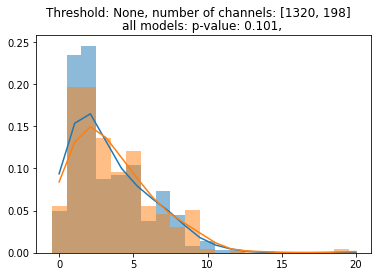

In [3]:
model_names = [
	'deepspeech2',
	'speech2text',
	'whisper_tiny',
	'whisper_base',
	'wav2vec2',
	'wav2letter_modified',
	# 'w2v2_generic'
	]
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
threshold = None
fig, ax = plt.subplots()
dist_core = []
dist_non_primary = []
for i, model_name in enumerate(model_names):
	corr_obj = Correlations(model_name+'_'+identifier)
	peak_layers, corr_dist = get_area_wise_histograms(
		model_name, identifier, bin_width, mVocs, threshold, corr_obj
	)
	dist_core.extend(peak_layers['core'])
	dist_non_primary.extend(peak_layers['non-primary'])

number_of_channels = [len(dist_core), len(dist_non_primary)]
peak_layers = {'core': dist_core, 'non-primary': dist_non_primary}
plot_overlapping_histograms(peak_layers, 'all models', ax=ax)
# plt.tight_layout()
plt.suptitle(f"Threshold: {threshold}, number of channels: {number_of_channels}")

Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Number of channels in core: 220
Number of channels in non-primary: 33


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Number of channels in core: 220
Number of channels in non-primary: 33


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 0.98, 'Threshold: None, number of channels: [220, 33]')

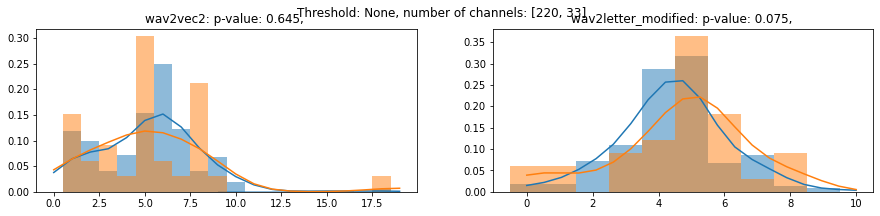

In [65]:
model_names = [
'wav2vec2',
'wav2letter_modified',
	]
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
# thresholds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
# for threshold in thresholds:
threshold = None
fig, ax = plt.subplots(nrows=1, ncols=len(model_names), figsize=(15, 3))
for i, model_name in enumerate(model_names):
	corr_obj = Correlations(model_name+'_'+identifier)
	peak_layers, corr_dist = get_area_wise_histograms(
		model_name, identifier, bin_width, mVocs, threshold, corr_obj
	)
	number_of_channels = [len(peak_layers['core']), len(peak_layers['non-primary'])]
	plot_overlapping_histograms(peak_layers, model_name, ax=ax[i])
# plt.tight_layout()
plt.suptitle(f"Threshold: {threshold}, number of channels: {number_of_channels}")

Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Number of channels in core: 204
Number of channels in non-primary: 24


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Number of channels in core: 204
Number of channels in non-primary: 24


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 0.98, 'Threshold: 0.09, number of channels: [204, 24]')

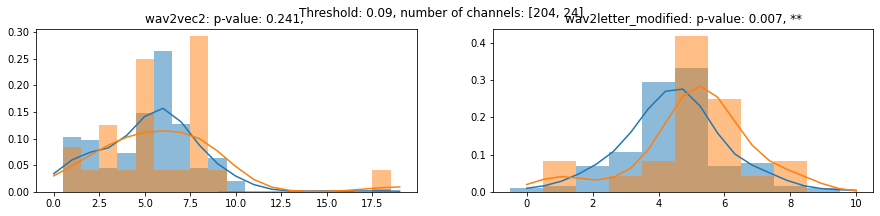

In [66]:
model_names = [
'wav2vec2',
'wav2letter_modified',
	]
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
# thresholds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
# for threshold in thresholds:
threshold = 0.09
fig, ax = plt.subplots(nrows=1, ncols=len(model_names), figsize=(15, 3))
for i, model_name in enumerate(model_names):
	corr_obj = Correlations(model_name+'_'+identifier)
	peak_layers, corr_dist = get_area_wise_histograms(
		model_name, identifier, bin_width, mVocs, threshold, corr_obj
	)
	number_of_channels = [len(peak_layers['core']), len(peak_layers['non-primary'])]
	plot_overlapping_histograms(peak_layers, model_name, ax=ax[i])
# plt.tight_layout()
plt.suptitle(f"Threshold: {threshold}, number of channels: {number_of_channels}")

Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Number of channels in core: 204
Number of channels in non-primary: 24


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Number of channels in core: 204
Number of channels in non-primary: 24


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Number of channels in core: 204
Number of channels in non-primary: 24


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Number of channels in core: 204
Number of channels in non-primary: 24


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 0.98, 'Threshold: 0.09, number of channels: [204, 24]')

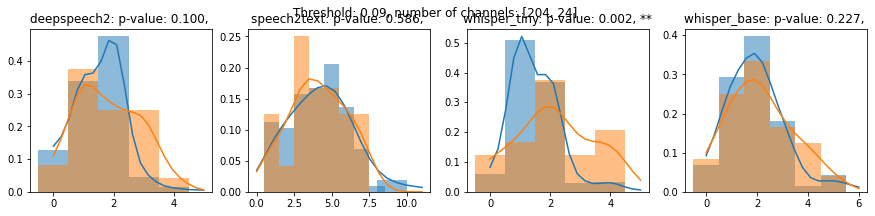

In [67]:
model_names = [
	'deepspeech2',
	'speech2text',
	'whisper_tiny',
	'whisper_base',
	]
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
# thresholds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
# for threshold in thresholds:
threshold = 0.09
fig, ax = plt.subplots(nrows=1, ncols=len(model_names), figsize=(15, 3))
for i, model_name in enumerate(model_names):
	corr_obj = Correlations(model_name+'_'+identifier)
	peak_layers, corr_dist = get_area_wise_histograms(
		model_name, identifier, bin_width, mVocs, threshold, corr_obj
	)
	number_of_channels = [len(peak_layers['core']), len(peak_layers['non-primary'])]
	plot_overlapping_histograms(peak_layers, model_name, ax=ax[i])
# plt.tight_layout()
plt.suptitle(f"Threshold: {threshold}, number of channels: {number_of_channels}")

Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Number of channels in core: 220
Number of channels in non-primary: 33


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Number of channels in core: 220
Number of channels in non-primary: 33


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Number of channels in core: 220
Number of channels in non-primary: 33


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Number of channels in core: 220
Number of channels in non-primary: 33


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 0.98, 'Threshold: None, number of channels: [220, 33]')

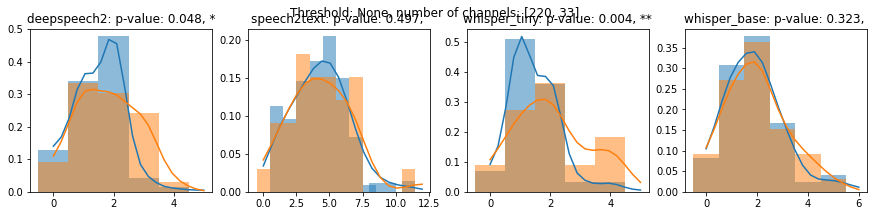

In [68]:
model_names = [
	'deepspeech2',
	'speech2text',
	'whisper_tiny',
	'whisper_base',
	]
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
# thresholds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
# for threshold in thresholds:
threshold = None
fig, ax = plt.subplots(nrows=1, ncols=len(model_names), figsize=(15, 3))
for i, model_name in enumerate(model_names):
	corr_obj = Correlations(model_name+'_'+identifier)
	peak_layers, corr_dist = get_area_wise_histograms(
		model_name, identifier, bin_width, mVocs, threshold, corr_obj
	)
	number_of_channels = [len(peak_layers['core']), len(peak_layers['non-primary'])]
	plot_overlapping_histograms(peak_layers, model_name, ax=ax[i])
# plt.tight_layout()
plt.suptitle(f"Threshold: {threshold}, number of channels: {number_of_channels}")

Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...
Number of channels in core: 227
Number of channels in non-primary: 81


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...
Number of channels in core: 227
Number of channels in non-primary: 81


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...
Number of channels in core: 227
Number of channels in non-primary: 81


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...
Number of channels in core: 227
Number of channels in non-primary: 81


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 0.98, 'Threshold: None, number of channels: [227, 81]')

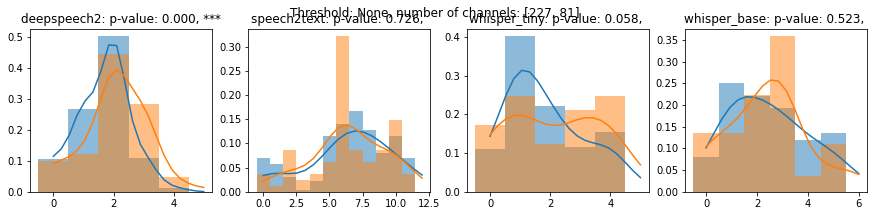

In [69]:
model_names = [
	'deepspeech2',
	'speech2text',
	'whisper_tiny',
	'whisper_base',
	]
identifier = 'mVocs_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = True
# thresholds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
# for threshold in thresholds:
threshold = None
fig, ax = plt.subplots(nrows=1, ncols=len(model_names), figsize=(15, 3))
for i, model_name in enumerate(model_names):
	corr_obj = Correlations(model_name+'_'+identifier)
	peak_layers, corr_dist = get_area_wise_histograms(
		model_name, identifier, bin_width, mVocs, threshold, corr_obj
	)
	number_of_channels = [len(peak_layers['core']), len(peak_layers['non-primary'])]
	plot_overlapping_histograms(peak_layers, model_name, ax=ax[i])
# plt.tight_layout()
plt.suptitle(f"Threshold: {threshold}, number of channels: {number_of_channels}")

Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Number of channels in core: 220
Number of channels in non-primary: 33


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Number of channels in core: 220
Number of channels in non-primary: 33


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Number of channels in core: 220
Number of channels in non-primary: 33


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Number of channels in core: 220
Number of channels in non-primary: 33


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Number of channels in core: 220
Number of channels in non-primary: 33


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 0.98, 'Threshold: None, number of channels: [220, 33]')

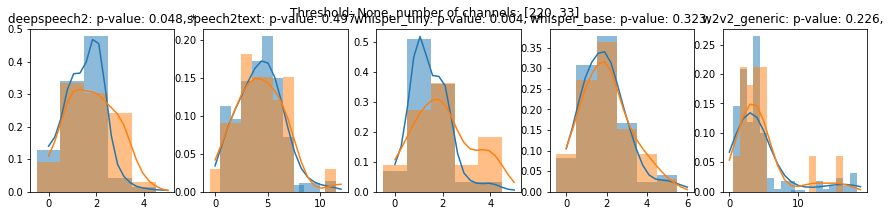

In [64]:
model_names = [
	'deepspeech2',
	'speech2text',
	'whisper_tiny',
	'whisper_base',
	'w2v2_generic'
	]
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
# thresholds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
# for threshold in thresholds:
threshold = None
fig, ax = plt.subplots(nrows=1, ncols=len(model_names), figsize=(15, 3))
for i, model_name in enumerate(model_names):
	corr_obj = Correlations(model_name+'_'+identifier)
	peak_layers, corr_dist = get_area_wise_histograms(
		model_name, identifier, bin_width, mVocs, threshold, corr_obj
	)
	number_of_channels = [len(peak_layers['core']), len(peak_layers['non-primary'])]
	plot_overlapping_histograms(peak_layers, model_name, ax=ax[i])
# plt.tight_layout()
plt.suptitle(f"Threshold: {threshold}, number of channels: {number_of_channels}")

Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Number of channels in core: 227
Number of channels in non-primary: 79


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Number of channels in core: 227
Number of channels in non-primary: 79


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Number of channels in core: 227
Number of channels in non-primary: 79


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Number of channels in core: 227
Number of channels in non-primary: 79


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Number of channels in core: 227
Number of channels in non-primary: 79


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 0.98, 'Threshold: 0.09, number of channels: [227, 79]')

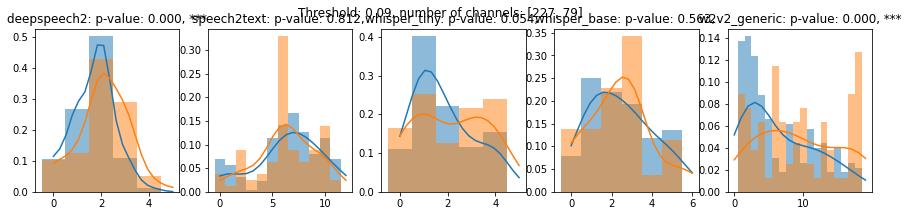

In [63]:
model_names = [
	'deepspeech2',
	'speech2text',
	'whisper_tiny',
	'whisper_base',
	'w2v2_generic'
	]
identifier = 'mVocs_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = True
# thresholds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
# for threshold in thresholds:
threshold = 0.09
fig, ax = plt.subplots(nrows=1, ncols=len(model_names), figsize=(15, 3))
for i, model_name in enumerate(model_names):
	corr_obj = Correlations(model_name+'_'+identifier)
	peak_layers, corr_dist = get_area_wise_histograms(
		model_name, identifier, bin_width, mVocs, threshold, corr_obj
	)
	number_of_channels = [len(peak_layers['core']), len(peak_layers['non-primary'])]
	plot_overlapping_histograms(peak_layers, model_name, ax=ax[i])
# plt.tight_layout()
plt.suptitle(f"Threshold: {threshold}, number of channels: {number_of_channels}")

Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.010 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.010 on column: 'mVocs_normalizer'...
Number of channels in core: 357


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Number of channels in non-primary: 273
Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.010 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.010 on column: 'mVocs_normalizer'...
Number of channels in core: 357


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Number of channels in non-primary: 273
Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.010 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.010 on column: 'mVocs_normalizer'...
Number of channels in core: 357
Number of channels in non-primary: 273


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.010 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.010 on column: 'mVocs_normalizer'...
Number of channels in core: 357
Number of channels in non-primary: 273


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.010 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.010 on column: 'mVocs_normalizer'...
Number of channels in core: 357
Number of channels in non-primary: 273


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.020 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.020 on column: 'mVocs_normalizer'...
Number of channels in core: 325
Number of channels in non-primary: 215


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.020 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.020 on column: 'mVocs_normalizer'...
Number of channels in core: 325
Number of channels in non-primary: 215


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.020 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.020 on column: 'mVocs_normalizer'...
Number of channels in core: 325
Number of channels in non-primary: 215


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.020 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.020 on column: 'mVocs_normalizer'...
Number of channels in core: 325
Number of channels in non-primary: 215


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.020 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.020 on column: 'mVocs_normalizer'...
Number of channels in core: 325
Number of channels in non-primary: 215


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.030 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.030 on column: 'mVocs_normalizer'...
Number of channels in core: 305
Number of channels in non-primary: 173


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.030 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.030 on column: 'mVocs_normalizer'...
Number of channels in core: 305
Number of channels in non-primary: 173


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.030 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.030 on column: 'mVocs_normalizer'...
Number of channels in core: 305
Number of channels in non-primary: 173


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.030 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.030 on column: 'mVocs_normalizer'...
Number of channels in core: 305
Number of channels in non-primary: 173


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.030 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.030 on column: 'mVocs_normalizer'...
Number of channels in core: 305
Number of channels in non-primary: 173


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.040 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.040 on column: 'mVocs_normalizer'...
Number of channels in core: 290
Number of channels in non-primary: 151


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.040 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.040 on column: 'mVocs_normalizer'...
Number of channels in core: 290
Number of channels in non-primary: 151


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.040 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.040 on column: 'mVocs_normalizer'...
Number of channels in core: 290
Number of channels in non-primary: 151


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.040 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.040 on column: 'mVocs_normalizer'...
Number of channels in core: 290
Number of channels in non-primary: 151


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.040 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.040 on column: 'mVocs_normalizer'...
Number of channels in core: 290
Number of channels in non-primary: 151


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.050 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.050 on column: 'mVocs_normalizer'...
Number of channels in core: 276
Number of channels in non-primary: 133


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.050 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.050 on column: 'mVocs_normalizer'...
Number of channels in core: 276
Number of channels in non-primary: 133


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.050 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.050 on column: 'mVocs_normalizer'...
Number of channels in core: 276
Number of channels in non-primary: 133


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.050 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.050 on column: 'mVocs_normalizer'...
Number of channels in core: 276
Number of channels in non-primary: 133


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.050 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.050 on column: 'mVocs_normalizer'...
Number of channels in core: 276
Number of channels in non-primary: 133


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.060 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.060 on column: 'mVocs_normalizer'...
Number of channels in core: 263
Number of channels in non-primary: 117


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.060 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.060 on column: 'mVocs_normalizer'...
Number of channels in core: 263
Number of channels in non-primary: 117


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.060 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.060 on column: 'mVocs_normalizer'...
Number of channels in core: 263
Number of channels in non-primary: 117


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.060 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.060 on column: 'mVocs_normalizer'...
Number of channels in core: 263
Number of channels in non-primary: 117


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.060 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.060 on column: 'mVocs_normalizer'...
Number of channels in core: 263
Number of channels in non-primary: 117


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.070 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.070 on column: 'mVocs_normalizer'...
Number of channels in core: 251
Number of channels in non-primary: 102


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.070 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.070 on column: 'mVocs_normalizer'...
Number of channels in core: 251
Number of channels in non-primary: 102


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.070 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.070 on column: 'mVocs_normalizer'...
Number of channels in core: 251
Number of channels in non-primary: 102


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.070 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.070 on column: 'mVocs_normalizer'...
Number of channels in core: 251
Number of channels in non-primary: 102


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.070 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.070 on column: 'mVocs_normalizer'...
Number of channels in core: 251
Number of channels in non-primary: 102


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.080 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.080 on column: 'mVocs_normalizer'...
Number of channels in core: 237
Number of channels in non-primary: 89


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.080 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.080 on column: 'mVocs_normalizer'...
Number of channels in core: 237
Number of channels in non-primary: 89


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.080 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.080 on column: 'mVocs_normalizer'...
Number of channels in core: 237
Number of channels in non-primary: 89


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.080 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.080 on column: 'mVocs_normalizer'...
Number of channels in core: 237
Number of channels in non-primary: 89


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.080 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.080 on column: 'mVocs_normalizer'...
Number of channels in core: 237
Number of channels in non-primary: 89


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Number of channels in core: 227
Number of channels in non-primary: 79


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Number of channels in core: 227
Number of channels in non-primary: 79


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Number of channels in core: 227
Number of channels in non-primary: 79


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Number of channels in core: 227
Number of channels in non-primary: 79


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.090 on column: 'mVocs_normalizer'...
Number of channels in core: 227
Number of channels in non-primary: 79


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.100 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.100 on column: 'mVocs_normalizer'...
Number of channels in core: 218
Number of channels in non-primary: 70


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.100 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.100 on column: 'mVocs_normalizer'...
Number of channels in core: 218
Number of channels in non-primary: 70


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.100 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.100 on column: 'mVocs_normalizer'...
Number of channels in core: 218
Number of channels in non-primary: 70


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.100 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.100 on column: 'mVocs_normalizer'...
Number of channels in core: 218
Number of channels in non-primary: 70


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.100 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.100 on column: 'mVocs_normalizer'...
Number of channels in core: 218
Number of channels in non-primary: 70


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.110 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.110 on column: 'mVocs_normalizer'...
Number of channels in core: 207
Number of channels in non-primary: 63


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.110 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.110 on column: 'mVocs_normalizer'...
Number of channels in core: 207
Number of channels in non-primary: 63


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.110 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.110 on column: 'mVocs_normalizer'...
Number of channels in core: 207
Number of channels in non-primary: 63


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.110 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.110 on column: 'mVocs_normalizer'...
Number of channels in core: 207
Number of channels in non-primary: 63


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.110 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.110 on column: 'mVocs_normalizer'...
Number of channels in core: 207
Number of channels in non-primary: 63


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.120 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.120 on column: 'mVocs_normalizer'...
Number of channels in core: 200
Number of channels in non-primary: 56


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.120 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.120 on column: 'mVocs_normalizer'...
Number of channels in core: 200
Number of channels in non-primary: 56


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.120 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.120 on column: 'mVocs_normalizer'...
Number of channels in core: 200
Number of channels in non-primary: 56


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.120 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.120 on column: 'mVocs_normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Number of channels in core: 200
Number of channels in non-primary: 56
Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.120 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.120 on column: 'mVocs_normalizer'...
Number of channels in core: 200
Number of channels in non-primary: 56


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.130 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.130 on column: 'mVocs_normalizer'...
Number of channels in core: 192
Number of channels in non-primary: 51


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.130 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.130 on column: 'mVocs_normalizer'...
Number of channels in core: 192
Number of channels in non-primary: 51


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.130 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.130 on column: 'mVocs_normalizer'...
Number of channels in core: 192
Number of channels in non-primary: 51


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.130 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.130 on column: 'mVocs_normalizer'...
Number of channels in core: 192
Number of channels in non-primary: 51


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.130 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.130 on column: 'mVocs_normalizer'...
Number of channels in core: 192
Number of channels in non-primary: 51


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.140 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.140 on column: 'mVocs_normalizer'...
Number of channels in core: 184
Number of channels in non-primary: 49


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.140 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.140 on column: 'mVocs_normalizer'...
Number of channels in core: 184
Number of channels in non-primary: 49


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.140 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.140 on column: 'mVocs_normalizer'...
Number of channels in core: 184
Number of channels in non-primary: 49


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.140 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.140 on column: 'mVocs_normalizer'...
Number of channels in core: 184
Number of channels in non-primary: 49


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.140 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.140 on column: 'mVocs_normalizer'...
Number of channels in core: 184
Number of channels in non-primary: 49


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.150 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.150 on column: 'mVocs_normalizer'...
Number of channels in core: 179
Number of channels in non-primary: 47


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.150 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.150 on column: 'mVocs_normalizer'...
Number of channels in core: 179
Number of channels in non-primary: 47


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.150 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.150 on column: 'mVocs_normalizer'...
Number of channels in core: 179
Number of channels in non-primary: 47


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.150 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.150 on column: 'mVocs_normalizer'...
Number of channels in core: 179
Number of channels in non-primary: 47


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.150 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.150 on column: 'mVocs_normalizer'...
Number of channels in core: 179
Number of channels in non-primary: 47


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


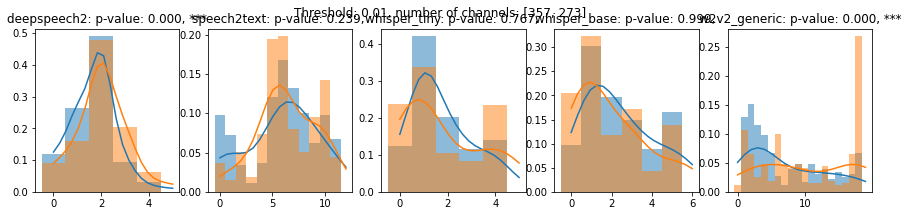

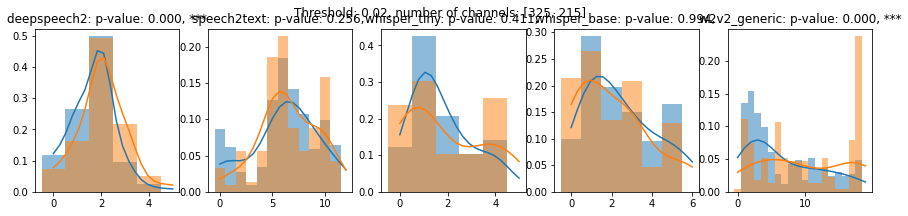

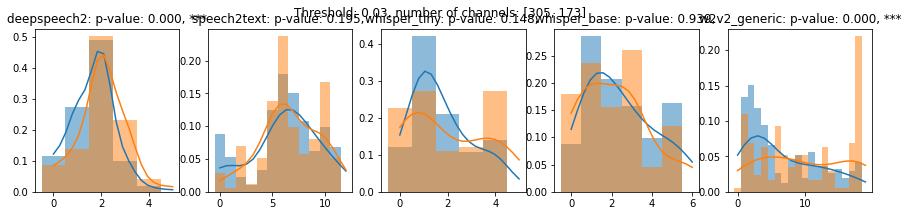

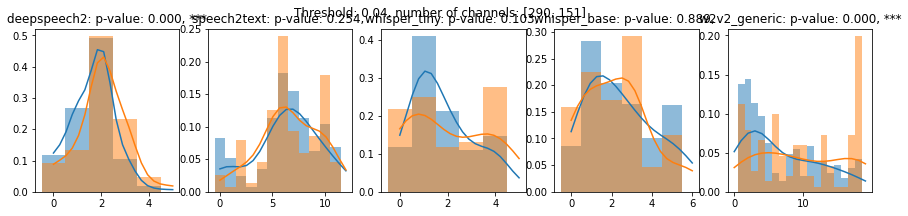

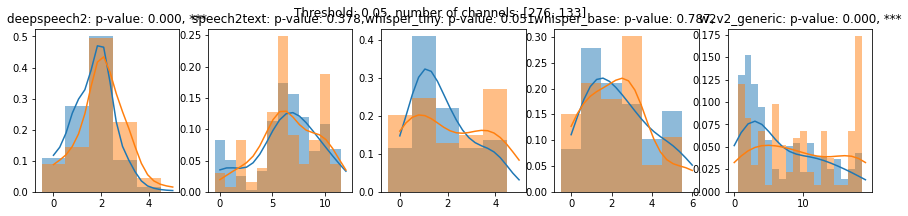

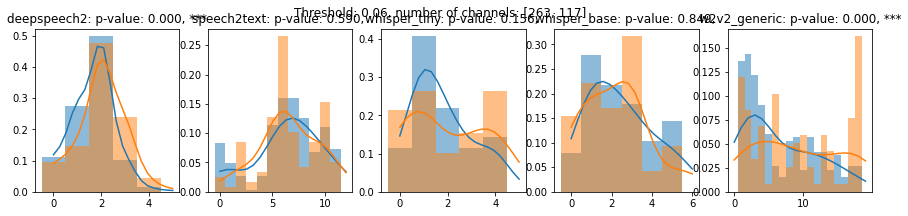

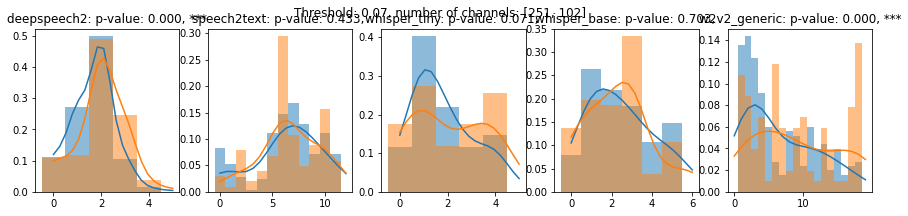

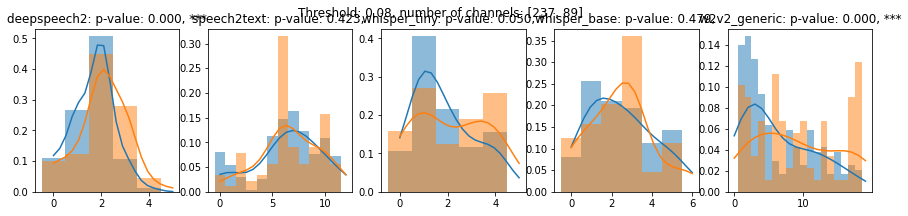

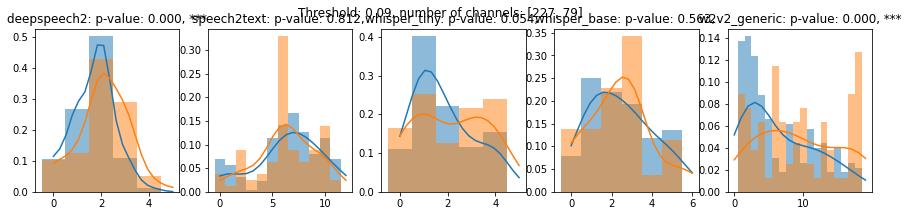

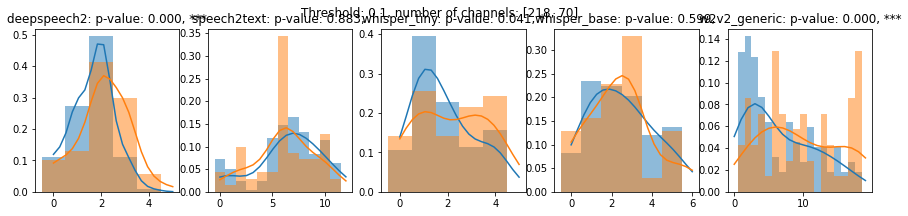

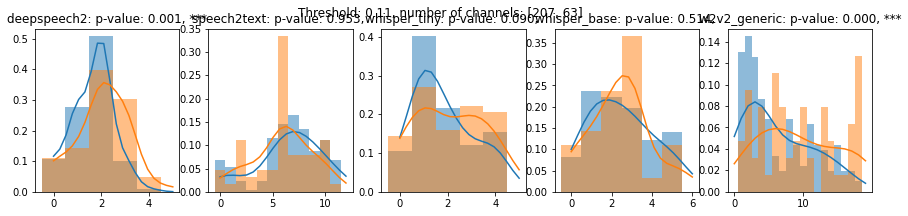

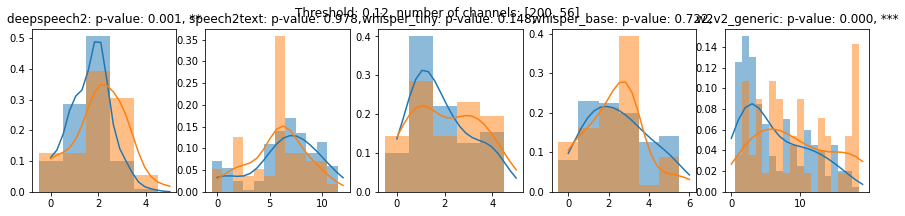

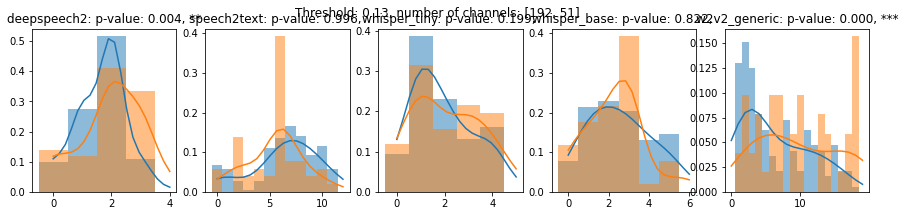

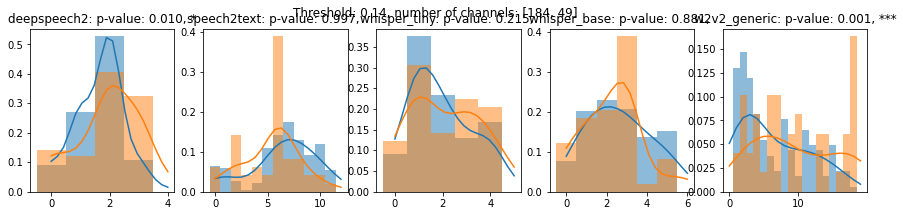

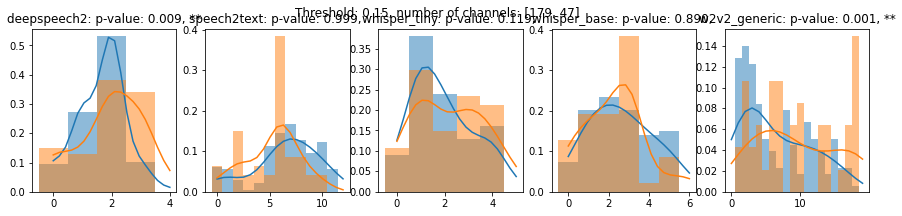

In [33]:
model_names = [
	'deepspeech2',
	'speech2text',
	'whisper_tiny',
	'whisper_base',
	'w2v2_generic'
	]
identifier = 'mVocs_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = True
thresholds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
for threshold in thresholds:
	fig, ax = plt.subplots(nrows=1, ncols=len(model_names), figsize=(15, 3))
	for i, model_name in enumerate(model_names):
		corr_obj = Correlations(model_name+'_'+identifier)
		peak_layers, corr_dist = get_area_wise_histograms(
			model_name, identifier, bin_width, mVocs, threshold, corr_obj
		)
		number_of_channels = [len(peak_layers['core']), len(peak_layers['non-primary'])]
		plot_overlapping_histograms(peak_layers, model_name, ax=ax[i])
	# plt.tight_layout()
	plt.suptitle(f"Threshold: {threshold}, number of channels: {number_of_channels}")

Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.010 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.010 on column: 'normalizer'...
Number of channels in core: 362
Number of channels in non-primary: 176


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.010 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.010 on column: 'normalizer'...
Number of channels in core: 362
Number of channels in non-primary: 176


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.010 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.010 on column: 'normalizer'...
Number of channels in core: 362
Number of channels in non-primary: 176


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.010 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.010 on column: 'normalizer'...
Number of channels in core: 362
Number of channels in non-primary: 176


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.020 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.020 on column: 'normalizer'...
Number of channels in core: 318
Number of channels in non-primary: 122


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.020 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.020 on column: 'normalizer'...
Number of channels in core: 318
Number of channels in non-primary: 122


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.020 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.020 on column: 'normalizer'...
Number of channels in core: 318
Number of channels in non-primary: 122


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.020 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.020 on column: 'normalizer'...
Number of channels in core: 318
Number of channels in non-primary: 122


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.030 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.030 on column: 'normalizer'...
Number of channels in core: 293
Number of channels in non-primary: 94


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.030 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.030 on column: 'normalizer'...
Number of channels in core: 293
Number of channels in non-primary: 94


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.030 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.030 on column: 'normalizer'...
Number of channels in core: 293
Number of channels in non-primary: 94


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.030 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.030 on column: 'normalizer'...
Number of channels in core: 293
Number of channels in non-primary: 94


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.040 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.040 on column: 'normalizer'...
Number of channels in core: 279
Number of channels in non-primary: 74


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.040 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.040 on column: 'normalizer'...
Number of channels in core: 279
Number of channels in non-primary: 74


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.040 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.040 on column: 'normalizer'...
Number of channels in core: 279
Number of channels in non-primary: 74


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.040 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.040 on column: 'normalizer'...
Number of channels in core: 279
Number of channels in non-primary: 74


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.050 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.050 on column: 'normalizer'...
Number of channels in core: 259
Number of channels in non-primary: 62


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.050 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.050 on column: 'normalizer'...
Number of channels in core: 259
Number of channels in non-primary: 62


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.050 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.050 on column: 'normalizer'...
Number of channels in core: 259
Number of channels in non-primary: 62


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.050 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.050 on column: 'normalizer'...
Number of channels in core: 259
Number of channels in non-primary: 62


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.060 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.060 on column: 'normalizer'...
Number of channels in core: 247
Number of channels in non-primary: 46


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.060 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.060 on column: 'normalizer'...
Number of channels in core: 247
Number of channels in non-primary: 46


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.060 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.060 on column: 'normalizer'...
Number of channels in core: 247
Number of channels in non-primary: 46


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.060 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.060 on column: 'normalizer'...
Number of channels in core: 247
Number of channels in non-primary: 46


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.070 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.070 on column: 'normalizer'...
Number of channels in core: 227
Number of channels in non-primary: 35


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.070 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.070 on column: 'normalizer'...
Number of channels in core: 227
Number of channels in non-primary: 35


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.070 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.070 on column: 'normalizer'...
Number of channels in core: 227
Number of channels in non-primary: 35


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.070 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.070 on column: 'normalizer'...
Number of channels in core: 227
Number of channels in non-primary: 35


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.080 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.080 on column: 'normalizer'...
Number of channels in core: 213
Number of channels in non-primary: 31


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.080 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.080 on column: 'normalizer'...
Number of channels in core: 213
Number of channels in non-primary: 31


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.080 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.080 on column: 'normalizer'...
Number of channels in core: 213
Number of channels in non-primary: 31


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.080 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.080 on column: 'normalizer'...
Number of channels in core: 213
Number of channels in non-primary: 31


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Number of channels in core: 204
Number of channels in non-primary: 24


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Number of channels in core: 204
Number of channels in non-primary: 24


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Number of channels in core: 204
Number of channels in non-primary: 24


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Number of channels in core: 204
Number of channels in non-primary: 24


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.100 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.100 on column: 'normalizer'...
Number of channels in core: 189
Number of channels in non-primary: 18


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.100 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.100 on column: 'normalizer'...
Number of channels in core: 189
Number of channels in non-primary: 18


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.100 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.100 on column: 'normalizer'...
Number of channels in core: 189
Number of channels in non-primary: 18


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.100 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.100 on column: 'normalizer'...
Number of channels in core: 189
Number of channels in non-primary: 18


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.110 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.110 on column: 'normalizer'...
Number of channels in core: 184
Number of channels in non-primary: 15


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.110 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.110 on column: 'normalizer'...
Number of channels in core: 184
Number of channels in non-primary: 15


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.110 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.110 on column: 'normalizer'...
Number of channels in core: 184
Number of channels in non-primary: 15


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.110 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.110 on column: 'normalizer'...
Number of channels in core: 184
Number of channels in non-primary: 15


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.120 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.120 on column: 'normalizer'...
Number of channels in core: 172
Number of channels in non-primary: 13


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.120 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.120 on column: 'normalizer'...
Number of channels in core: 172
Number of channels in non-primary: 13


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.120 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.120 on column: 'normalizer'...
Number of channels in core: 172
Number of channels in non-primary: 13


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.120 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.120 on column: 'normalizer'...
Number of channels in core: 172
Number of channels in non-primary: 13


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.130 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.130 on column: 'normalizer'...
Number of channels in core: 166
Number of channels in non-primary: 13


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.130 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.130 on column: 'normalizer'...
Number of channels in core: 166
Number of channels in non-primary: 13


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.130 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.130 on column: 'normalizer'...
Number of channels in core: 166
Number of channels in non-primary: 13


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.130 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.130 on column: 'normalizer'...
Number of channels in core: 166
Number of channels in non-primary: 13


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.140 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.140 on column: 'normalizer'...
Number of channels in core: 155
Number of channels in non-primary: 12


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.140 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.140 on column: 'normalizer'...
Number of channels in core: 155
Number of channels in non-primary: 12


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.140 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.140 on column: 'normalizer'...
Number of channels in core: 155
Number of channels in non-primary: 12


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.140 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.140 on column: 'normalizer'...
Number of channels in core: 155
Number of channels in non-primary: 12


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.150 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.150 on column: 'normalizer'...
Number of channels in core: 147
Number of channels in non-primary: 10


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.150 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.150 on column: 'normalizer'...
Number of channels in core: 147
Number of channels in non-primary: 10


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.150 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.150 on column: 'normalizer'...
Number of channels in core: 147
Number of channels in non-primary: 10


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.150 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.150 on column: 'normalizer'...
Number of channels in core: 147
Number of channels in non-primary: 10


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


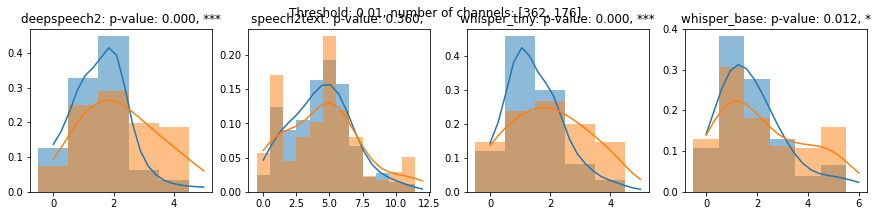

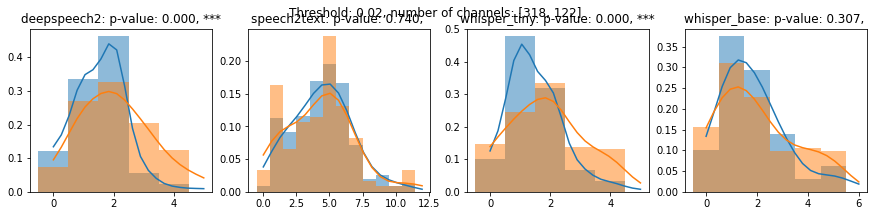

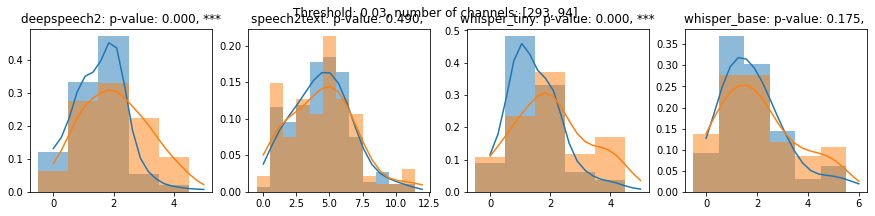

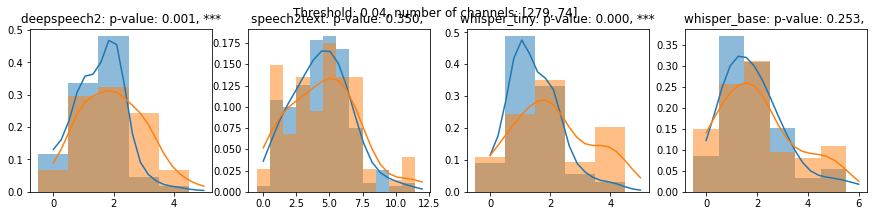

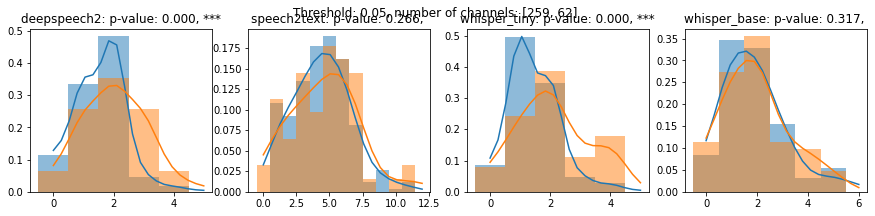

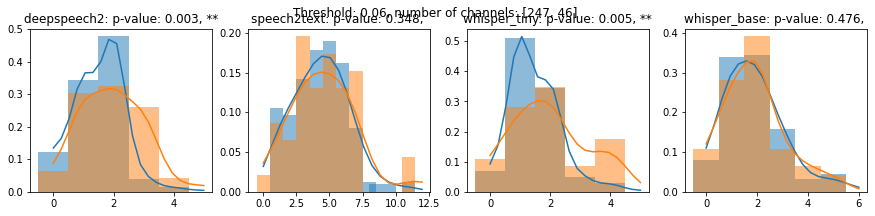

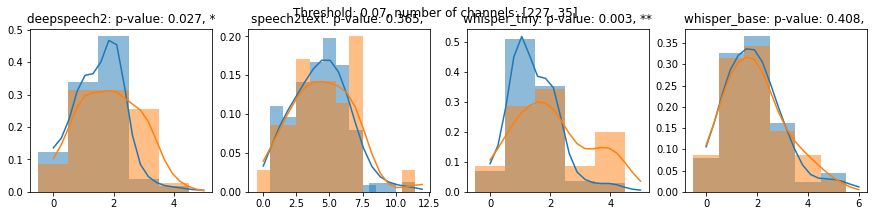

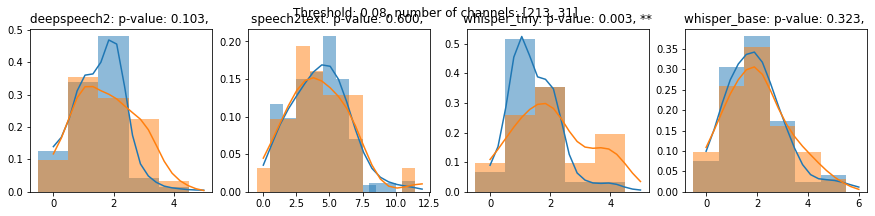

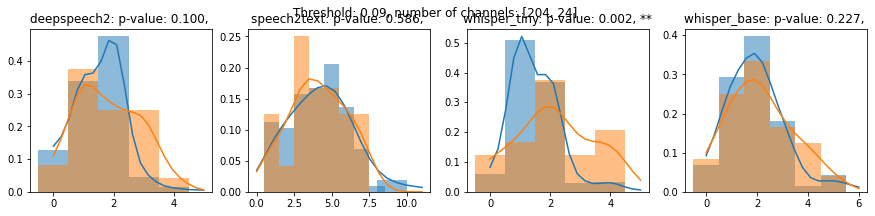

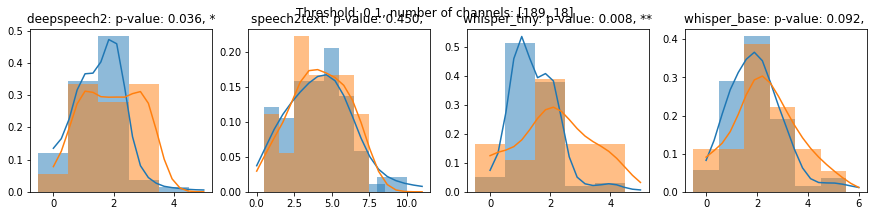

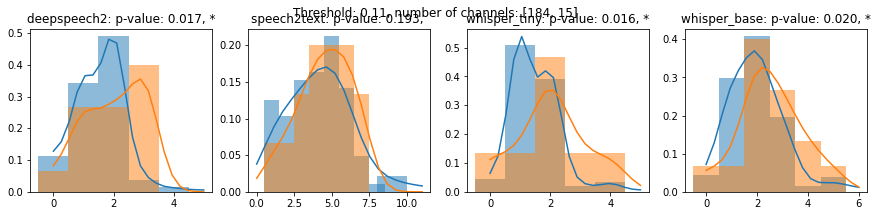

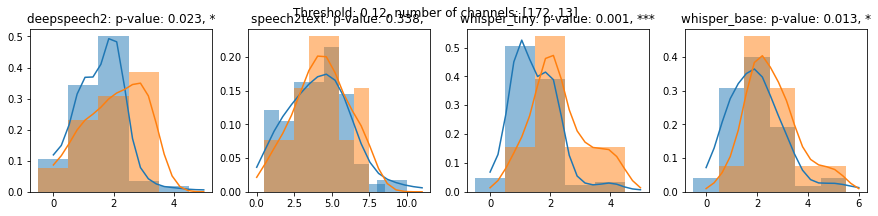

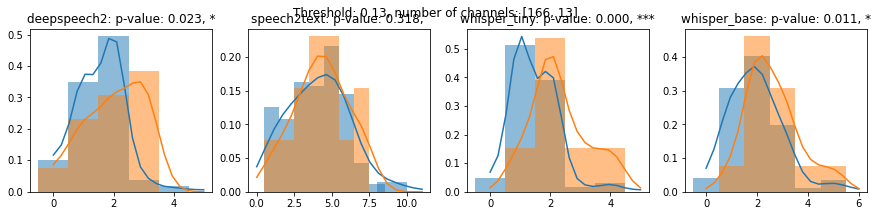

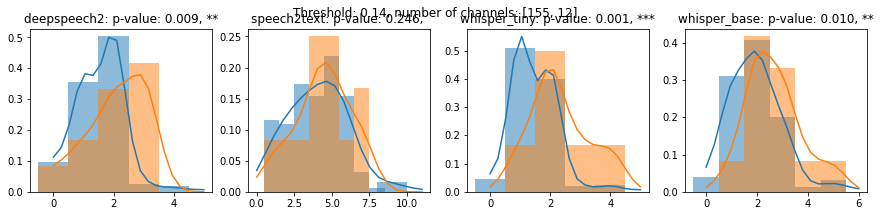

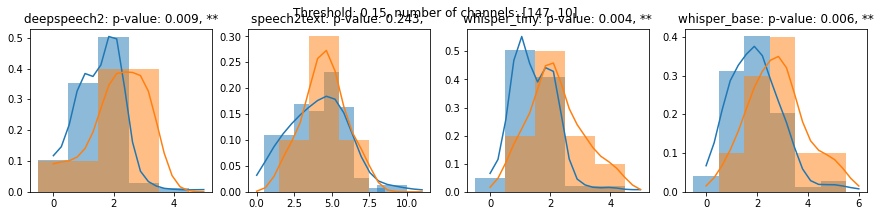

In [30]:
model_names = [
	'deepspeech2',
	'speech2text',
	'whisper_tiny',
	'whisper_base'
	]
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
thresholds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
for threshold in thresholds:
	fig, ax = plt.subplots(nrows=1, ncols=len(model_names), figsize=(15, 3))
	for i, model_name in enumerate(model_names):
		corr_obj = Correlations(model_name+'_'+identifier)
		peak_layers, corr_dist = get_area_wise_histograms(
			model_name, identifier, bin_width, mVocs, threshold, corr_obj
		)
		number_of_channels = [len(peak_layers['core']), len(peak_layers['non-primary'])]
		plot_overlapping_histograms(peak_layers, model_name, ax=ax[i])
	# plt.tight_layout()
	plt.suptitle(f"Threshold: {threshold}, number of channels: {number_of_channels}")

In [4]:
set(peak_layers['core'])

{0, 1, 2, 3, 4, 5}

In [130]:
from scipy.stats import chi2_contingency
from collections import Counter

counter1 = Counter(peak_layers['core'])
counter2 = Counter(peak_layers['non-primary'])
all_categories = sorted(set(counter1.keys()).union(set(counter2.keys())))
    
# Create the contingency table
freq1 = [counter1.get(cat, 0) for cat in all_categories]
freq2 = [counter2.get(cat, 0) for cat in all_categories]
contingency_table = np.array([freq1, freq2])

# # Perform the Chi-Square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-Square Statistic: {chi2_stat}')
print(f'P-value: {p_value}')
print(f'Degrees of Freedom: {dof}')
print(f'Expected Frequencies: {expected}')

Chi-Square Statistic: 20.8122347988958
P-value: 0.0008789602318618888
Degrees of Freedom: 5
Expected Frequencies: [[ 26.95652174  74.7826087  100.          14.7826087    2.60869565
    0.86956522]
 [  4.04347826  11.2173913   15.           2.2173913    0.39130435
    0.13043478]]


In [127]:
contingency_table

array([[ 28,  75, 105,   9,   2,   1],
       [  3,  11,  10,   8,   1,   0]])

In [82]:

chisquare(f_obs, f_exp=None, ddof=0, axis=0)[source]


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.120 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.120 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.110 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.110 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.100 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.100 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.080 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.080 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold:

/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for 

Extracting column: normalized_test_cc
Applying threshold: 0.060 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.060 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.050 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.050 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.040 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.040 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.030 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.030 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.020 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.020 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for 

Text(0.5, 0.98, 'Model: deepspeech2')

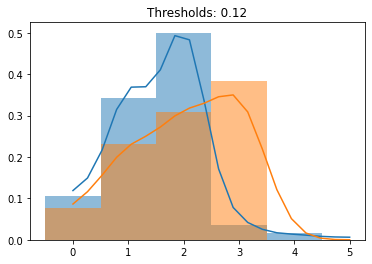

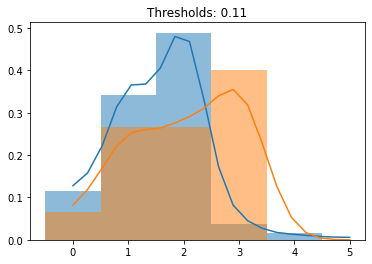

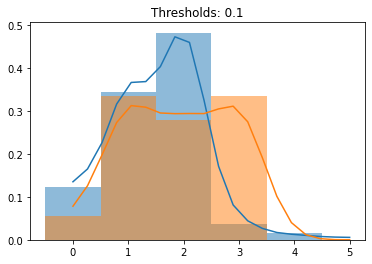

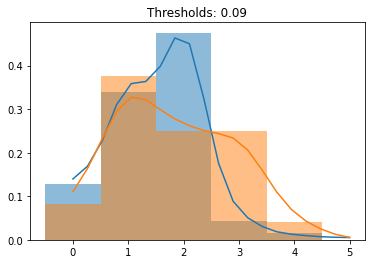

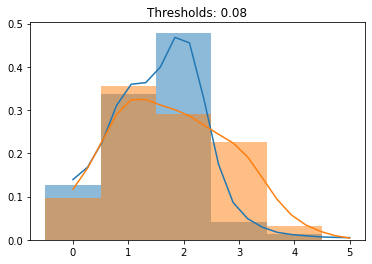

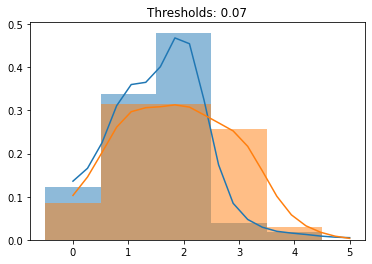

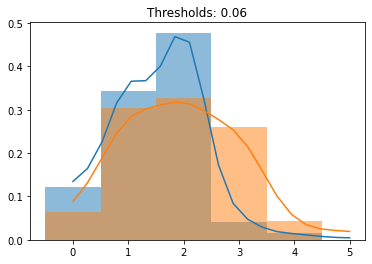

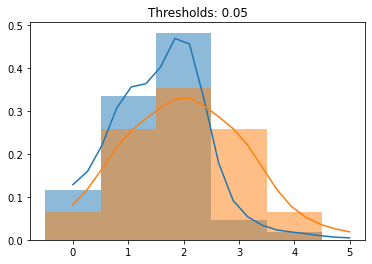

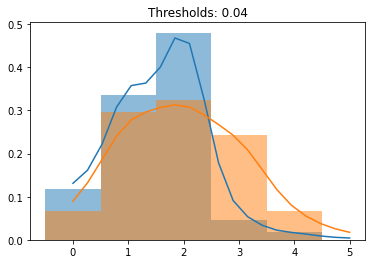

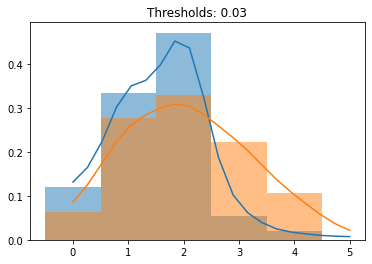

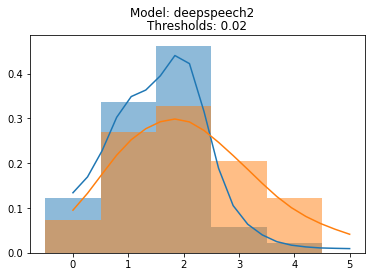

In [105]:
model_name = 'deepspeech2'
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
threshold = None
corr_obj = Correlations(model_name+'_'+identifier)
thresholds = [0.12, 0.11, 0.10, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02]
for threshold in thresholds:
	peak_layers, corr_dist = get_area_wise_histograms(
		model_name, identifier, bin_width, mVocs, threshold, corr_obj
	)
	fig, ax = plt.subplots()
	plot_overlapping_histograms(peak_layers)
	plt.title(f"Thresholds: {threshold}")
plt.suptitle(f"Model: {model_name}")

Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.120 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.120 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.110 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.110 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.100 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.100 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.080 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.080 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold:

/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for 

Extracting column: normalized_test_cc
Applying threshold: 0.060 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.060 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.050 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.050 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.040 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.040 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.030 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.030 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.020 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.020 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for 

Text(0.5, 0.98, 'Model: whisper_base')

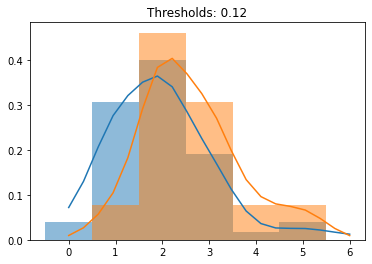

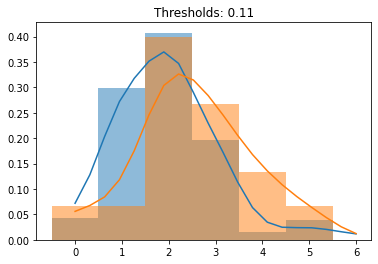

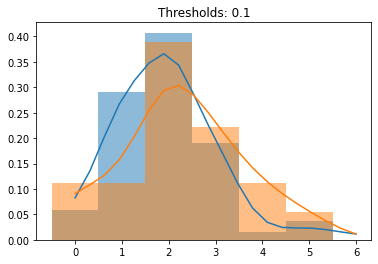

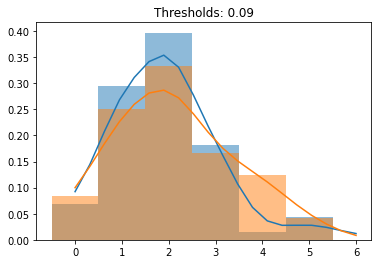

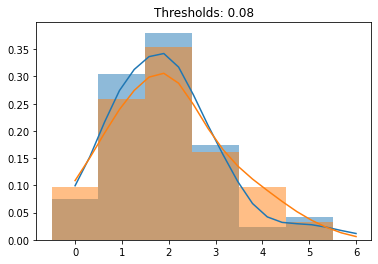

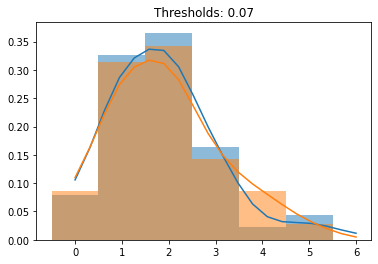

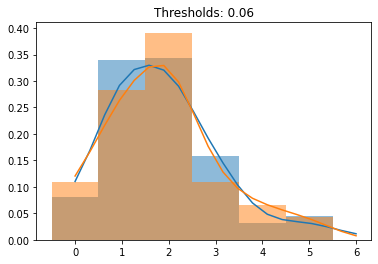

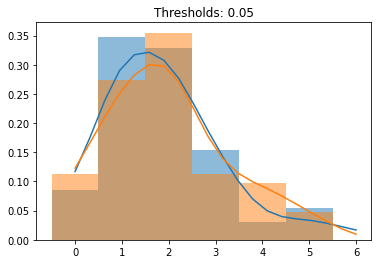

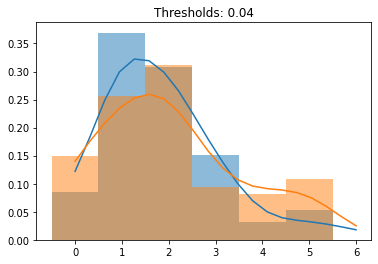

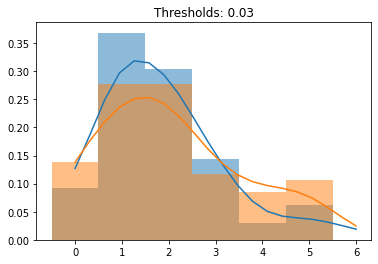

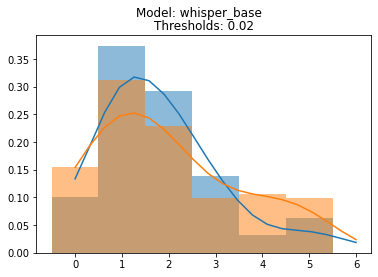

In [106]:
model_name = 'whisper_base'
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
threshold = None
corr_obj = Correlations(model_name+'_'+identifier)
thresholds = [0.12, 0.11, 0.10, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02]
for threshold in thresholds:
	peak_layers, corr_dist = get_area_wise_histograms(
		model_name, identifier, bin_width, mVocs, threshold, corr_obj
	)
	fig, ax = plt.subplots()
	plot_overlapping_histograms(peak_layers)
	plt.title(f"Thresholds: {threshold}")
plt.suptitle(f"Model: {model_name}")

Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.120 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.120 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.110 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.110 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.100 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.100 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Extracting column: normalized_test_cc


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for 

Applying threshold: 0.080 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.080 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.070 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.070 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.060 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.060 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.050 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.050 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.040 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.040 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for 

Extracting column: normalized_test_cc
Applying threshold: 0.030 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.030 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.020 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.020 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for 

Text(0.5, 0.98, 'Model: speech2text')

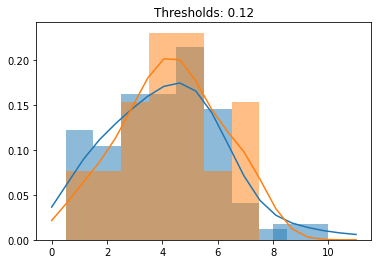

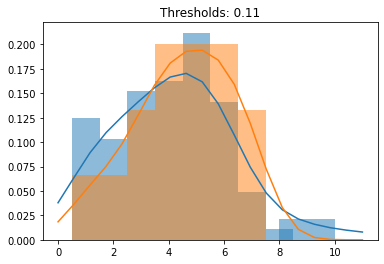

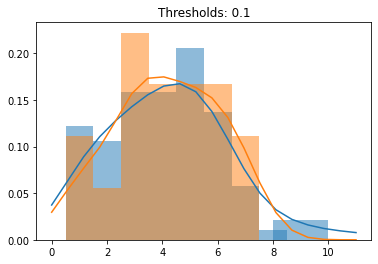

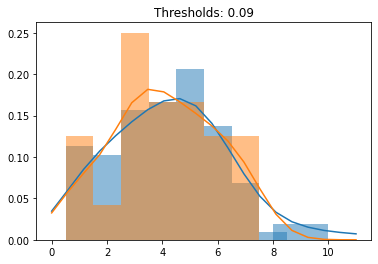

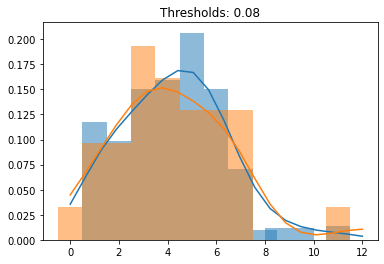

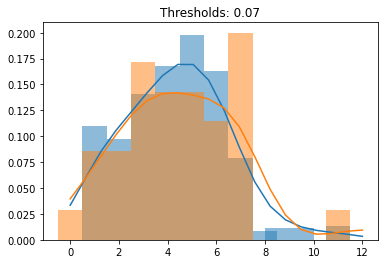

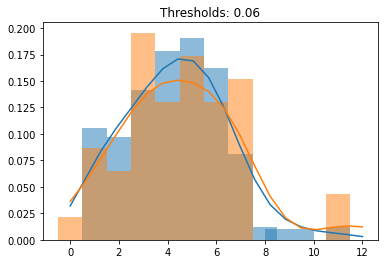

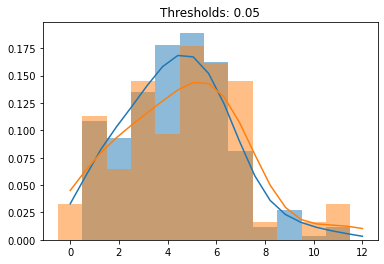

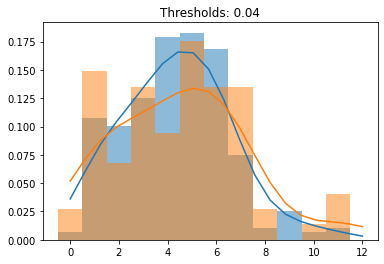

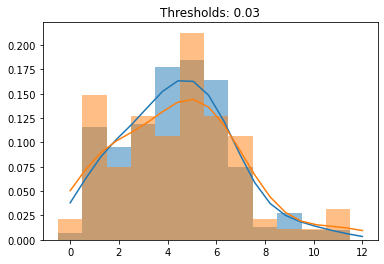

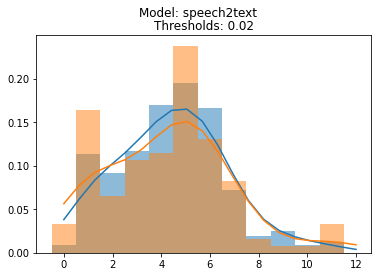

In [107]:
model_name = 'speech2text'
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
threshold = None
corr_obj = Correlations(model_name+'_'+identifier)
thresholds = [0.12, 0.11, 0.10, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02]
for threshold in thresholds:
	peak_layers, corr_dist = get_area_wise_histograms(
		model_name, identifier, bin_width, mVocs, threshold, corr_obj
	)
	fig, ax = plt.subplots()
	plot_overlapping_histograms(peak_layers)
	plt.title(f"Thresholds: {threshold}")
plt.suptitle(f"Model: {model_name}")

Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.120 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.120 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.110 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.110 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.100 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.100 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.090 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.080 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.080 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold:

/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for 

Extracting column: normalized_test_cc
Applying threshold: 0.060 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.060 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.050 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.050 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.040 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.040 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.030 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.030 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.020 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.020 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for 

Text(0.5, 0.98, 'Model: whisper_tiny')

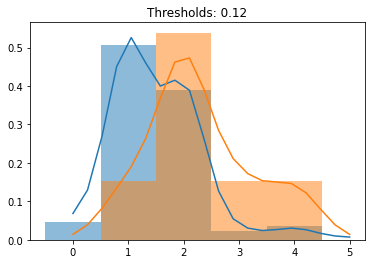

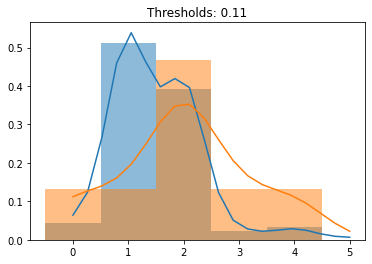

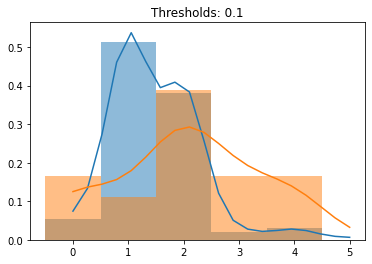

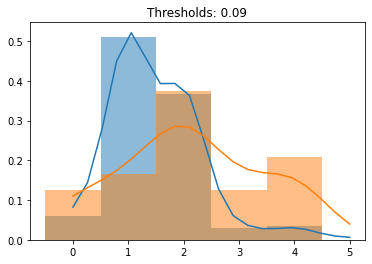

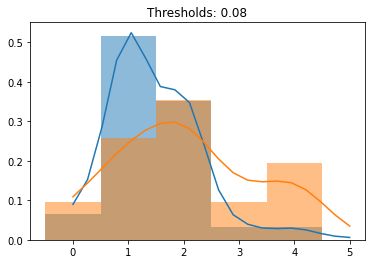

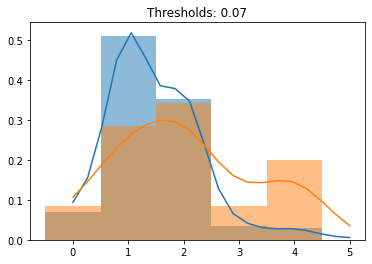

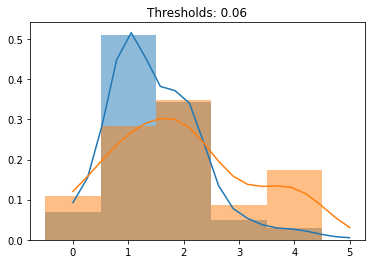

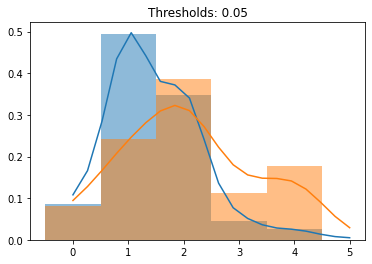

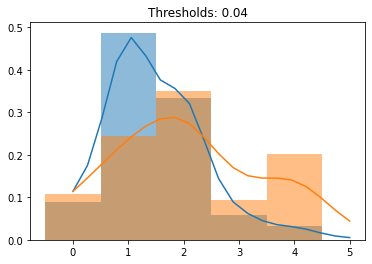

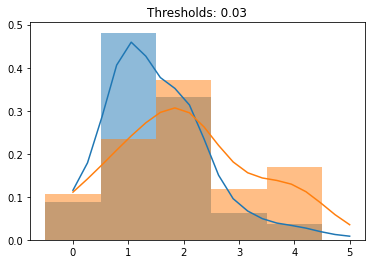

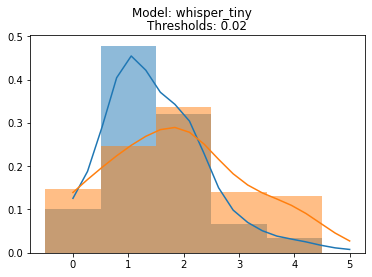

In [108]:
model_name = 'whisper_tiny'
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
threshold = None
corr_obj = Correlations(model_name+'_'+identifier)
thresholds = [0.12, 0.11, 0.10, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02]
for threshold in thresholds:
	peak_layers, corr_dist = get_area_wise_histograms(
		model_name, identifier, bin_width, mVocs, threshold, corr_obj
	)
	fig, ax = plt.subplots()
	plot_overlapping_histograms(peak_layers)
	plt.title(f"Thresholds: {threshold}")
plt.suptitle(f"Model: {model_name}")

Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.110 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.110 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


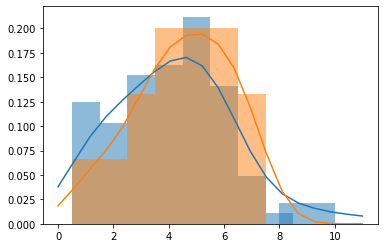

In [95]:
model_name = 'speech2text'
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
threshold = 0.11

peak_layers, corr_dist = get_area_wise_histograms(
	model_name, identifier, bin_width, mVocs, threshold
)
plot_overlapping_histograms(peak_layers)

Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.092 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.092 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


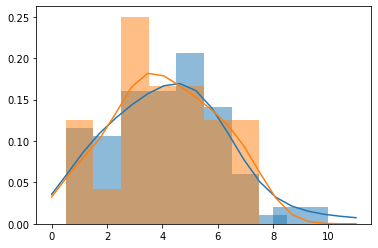

In [94]:
model_name = 'speech2text'
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
threshold = 0.092

peak_layers, corr_dist = get_area_wise_histograms(
	model_name, identifier, bin_width, mVocs, threshold
)
plot_overlapping_histograms(peak_layers)

Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.070 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.070 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


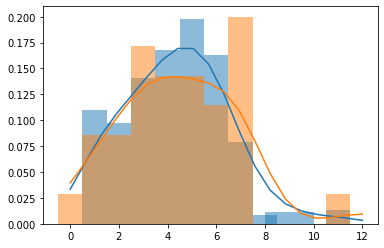

In [96]:
model_name = 'speech2text'
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
threshold = 0.07

peak_layers, corr_dist = get_area_wise_histograms(
	model_name, identifier, bin_width, mVocs, threshold
)
plot_overlapping_histograms(peak_layers)

Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.060 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.060 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


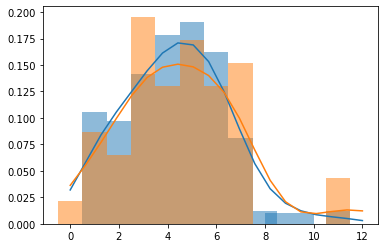

In [98]:
model_name = 'speech2text'
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
threshold = 0.06

peak_layers, corr_dist = get_area_wise_histograms(
	model_name, identifier, bin_width, mVocs, threshold
)
plot_overlapping_histograms(peak_layers)

Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.050 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.050 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


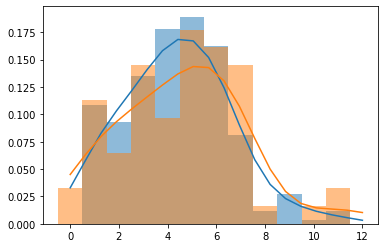

In [99]:
model_name = 'speech2text'
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
threshold = 0.05

peak_layers, corr_dist = get_area_wise_histograms(
	model_name, identifier, bin_width, mVocs, threshold
)
plot_overlapping_histograms(peak_layers)

Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.040 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.040 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


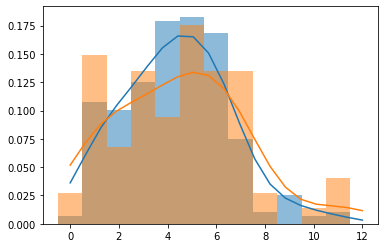

In [97]:
model_name = 'speech2text'
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
threshold = 0.04

peak_layers, corr_dist = get_area_wise_histograms(
	model_name, identifier, bin_width, mVocs, threshold
)
plot_overlapping_histograms(peak_layers)

Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.030 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.030 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


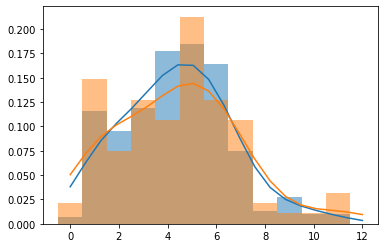

In [100]:
model_name = 'speech2text'
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
threshold = 0.03

peak_layers, corr_dist = get_area_wise_histograms(
	model_name, identifier, bin_width, mVocs, threshold
)
plot_overlapping_histograms(peak_layers)

Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.020 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.020 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


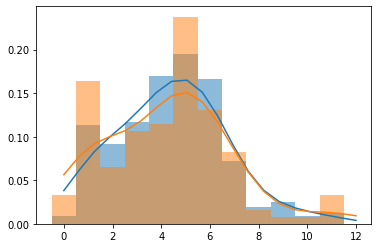

In [101]:
model_name = 'speech2text'
identifier = 'timit_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = False
threshold = 0.02

peak_layers, corr_dist = get_area_wise_histograms(
	model_name, identifier, bin_width, mVocs, threshold
)
plot_overlapping_histograms(peak_layers)

In [66]:
def plot_area_wise_histogram(model_name, threshold=None):
	corr_obj = Correlations(model_name+'_'+identifier)
	if threshold is None:
		threshold = corr_obj.get_normalizer_threshold(
			bin_width=bin_width, poisson_normalizer=poisson_normalizer,
			mVocs=mVocs
	)
	peak_layer_areas = {}
	corr_dist_areas = {}
	neural_areas = ['core', 'non-primary']
	for area in neural_areas:
		data_dist_trained = corr_obj.get_corr_all_layers_for_bin_width(
			neural_area=area, bin_width=bin_width, delay=delay,
			threshold=threshold, normalized=normalized,
			column=column, mVocs=mVocs, use_stat_inclusion=use_stat_inclusion,
			inclusion_p_threshold=inclusion_p_threshold,
			use_poisson_null=use_poisson_null,
		)

		layer_ids = np.arange(len(data_dist_trained.keys()))
		corr_dist = np.stack(data_dist_trained.values(), axis=0)
		peak_layer_areas[area] = layer_ids[np.argmax(corr_dist, axis=0)]
		corr_dist_areas[area] = corr_dist

	fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
	for i, area in enumerate(neural_areas):

		ax[i].hist(peak_layer_areas[area], bins=layer_ids , density=True, alpha=0.5, label=area)
		ax[i].set_xticks(layer_ids,layer_ids)
		ax[i].set_title(area)
		ax[i].set_xlabel('Layer')
		ax[i].set_ylabel('# channels')

	plt.suptitle(model_name)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...
Extracting column: normalized_test_cc
Applying threshold: 0.073 on column: 'normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


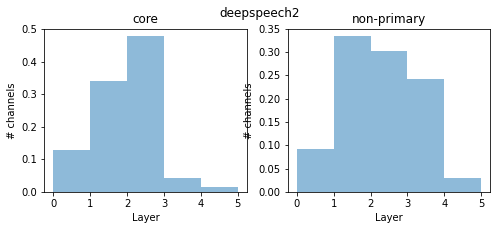

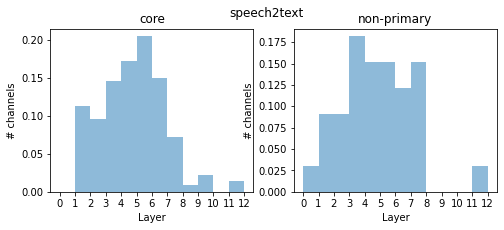

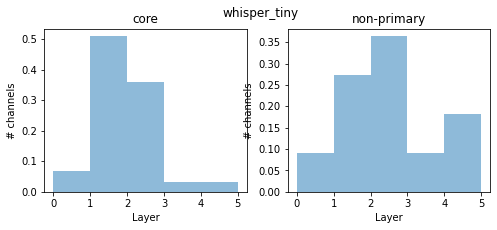

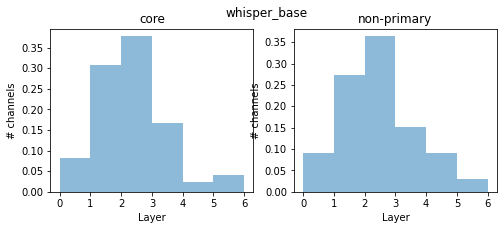

In [68]:
model_names = [
	'deepspeech2',
	'speech2text',
	'whisper_tiny',
	'whisper_base',
]
threshold = None
for model_name in model_names:
# /model_name = 'whisper_base'
	plot_area_wise_histogram(model_name, threshold)

In [69]:
# model_name = 'whisper_base'
identifier = 'mVocs_trf_lags300_bw50_naplib_matched'
bin_width = 50
mVocs = True
area = 'core'
threshold = None
poisson_normalizer = True
normalized = True
delay = 0
column = None
use_stat_inclusion = False
inclusion_p_threshold = 0.01
use_poisson_null = True


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


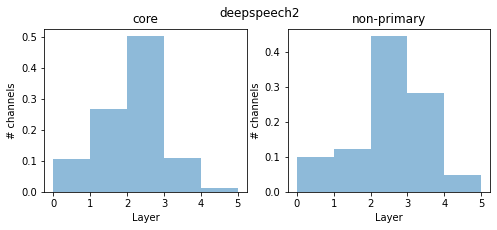

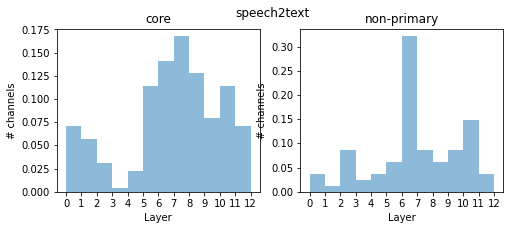

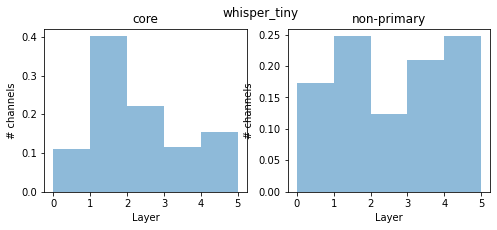

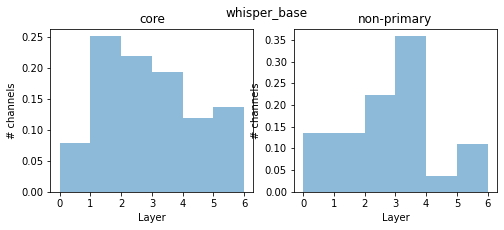

In [70]:
model_names = [
	'deepspeech2',
	'speech2text',
	'whisper_tiny',
	'whisper_base',
]
threshold = None
for model_name in model_names:
# /model_name = 'whisper_base'
	plot_area_wise_histogram(model_name, threshold)

#### weights...

In [2]:
def get_sig_sess_channels(mVocs=False, threshold=None):
	model_name = 'whisper_base'
	identifier = 'timit_trf_lags300_bw50_naplib_matched'
	bin_width = 50
	poisson_normalizer = True
	normalized = True
	delay = 0
	column = None
	use_stat_inclusion = False
	inclusion_p_threshold = 0.01
	use_poisson_null = True

	corr_obj = Correlations(model_name+'_'+identifier)
	if threshold is None:
		threshold = corr_obj.get_normalizer_threshold(
			bin_width=bin_width, poisson_normalizer=poisson_normalizer,
			mVocs=mVocs
	)
	neural_areas = ['core', 'non-primary']
	sig_sess_channels = {}
	# layer_id = 2
	for area in neural_areas:
		area_sessions = corr_obj.metadata.get_all_sessions(area)
		select_data = corr_obj.get_selected_data(
			sessions=area_sessions, 
			bin_width=bin_width,
			delay=delay,
			threshold=threshold,
			# N_sents=N_sents,
			mVocs=mVocs,
		)
		session_channel = {}
		layer_ids = select_data['layer'].unique()
		sessions = select_data['session'].unique()
		# layer = layer_ids[0]
		select_layer = select_data[select_data['layer']==layer_ids[0]]
		for sess in sessions:
			select_session = select_layer[select_layer['session']==sess]
			channels = select_session['channel'].unique()
			session_channel[sess] = channels

		sig_sess_channels[area] = session_channel

	return sig_sess_channels


def read_betas(model_name, session, bin_width=50, shuffled=False):
	betas = io.read_trf_parameters(model_name, session, bin_width, shuffled, verbose=False)
	return betas



In [11]:
mVocs=False
threshold=0.07
sig_sess_channels = get_sig_sess_channels(mVocs=mVocs, threshold=threshold)

Using default normalizer file...
Applying threshold: 0.070 on column: 'normalizer'...
Applying threshold: 0.070 on column: 'normalizer'...


In [12]:
total_channels = 0
for sess in sig_sess_channels['core']:
	print(f"Session: {sess}, Number of channels: {len(sig_sess_channels['core'][sess])}")

	total_channels += len(sig_sess_channels['core'][sess])
print(f"Total channels: {total_channels}")

Session: 180627.0, Number of channels: 4
Session: 180719.0, Number of channels: 6
Session: 180720.0, Number of channels: 9
Session: 180731.0, Number of channels: 14
Session: 180807.0, Number of channels: 13
Session: 180808.0, Number of channels: 5
Session: 180814.0, Number of channels: 20
Session: 190606.0, Number of channels: 8
Session: 191113.0, Number of channels: 28
Session: 191125.0, Number of channels: 14
Session: 191206.0, Number of channels: 14
Session: 200206.0, Number of channels: 63
Session: 200207.0, Number of channels: 13
Session: 200213.0, Number of channels: 16
Total channels: 227


In [13]:
total_channels = 0
area = 'non-primary'
for sess in sig_sess_channels[area]:
	print(f"Session: {sess}, Number of channels: {len(sig_sess_channels[area][sess])}")

	total_channels += len(sig_sess_channels[area][sess])
print(f"Total channels: {total_channels}")

Session: 180613.0, Number of channels: 1
Session: 180728.0, Number of channels: 2
Session: 180730.0, Number of channels: 1
Session: 191115.0, Number of channels: 1
Session: 191121.0, Number of channels: 12
Session: 191210.0, Number of channels: 4
Session: 200205.0, Number of channels: 11
Session: 200219.0, Number of channels: 3
Total channels: 35


In [35]:
def visualize_parameters(model_name, layer_id, sig_sess_channels):
	neural_areas = ['core', 'non-primary']
	sig_betas_mean = {}
	# layer_id = 2
	for area in neural_areas:
		session_channel = sig_sess_channels[area]
		sig_betas = []
		for sess in session_channel.keys():
			sess = int(sess)
			betas = read_betas(model_name, sess)
			sig_betas.append(betas[layer_id][:,:,session_channel[sess].astype(int)].mean(axis=0))
			# print(sess, session_channels[sess])
		sig_betas = np.concatenate(sig_betas, axis=-1)
		
		sig_betas_mean[area] = sig_betas


	core_dist = {i:sig_betas_mean['core'][i] for i in range(sig_betas_mean['core'].shape[0])}
	np_dist = {i:sig_betas_mean['non-primary'][i] for i in range(sig_betas_mean['non-primary'].shape[0])}
	ax=RegPlotter.plot_line_with_shaded_region(
				data_dict=core_dist, color='tab:blue', alpha=0.2,
				display_inter_quartile_range=True,
				display_dotted_lines=False,
				)
	ax=RegPlotter.plot_line_with_shaded_region(
				data_dict=np_dist, color='tab:orange', alpha=0.2,
				display_inter_quartile_range=True,
				display_dotted_lines=False, ax=ax
				)

	# plt.plot(sig_betas_mean['core'].mean(axis=-1), label='core')
	# plt.plot(sig_betas_mean['non-primary'].mean(axis=-1), label='non-primary')
	ax.legend()
	ax.set_title(f"{model_name}, L-{layer_id}")

	return sig_betas_mean

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Peak corr (median): 2.8967334307788736e-05, occurs at x_coordinate: 0
Peak corr (max): 0.0004047494094855384, occurs at x_coordinate: 0
Peak corr (median): 2.148232536231991e-05, occurs at x_coordinate: 0
Peak corr (max): 3.5538035194567805e-05, occurs at x_coordinate: 0


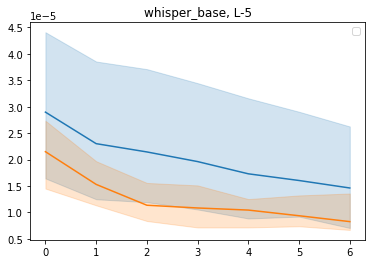

In [54]:
model_name = 'whisper_base'
layer_id = 5
sig_betas_mean = visualize_parameters(model_name, layer_id, sig_sess_channels)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Peak corr (median): 6.71322893307439e-05, occurs at x_coordinate: 0
Peak corr (max): 0.001798918255172022, occurs at x_coordinate: 0
Peak corr (median): 7.465437184241797e-05, occurs at x_coordinate: 0
Peak corr (max): 0.00037077921681518517, occurs at x_coordinate: 0


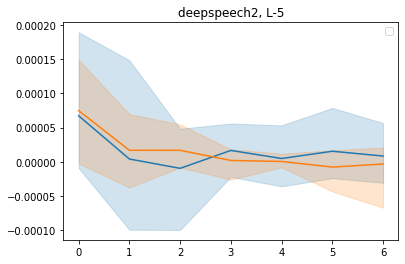

In [59]:
model_name = 'deepspeech2'
layer_id = 5
sig_betas_mean = visualize_parameters(model_name, layer_id, sig_sess_channels)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Peak corr (median): 1.3358228423888811e-06, occurs at x_coordinate: 5
Peak corr (max): 0.0012371278814679284, occurs at x_coordinate: 5
Peak corr (median): 2.951101900617954e-05, occurs at x_coordinate: 5
Peak corr (max): 0.0005311714497882963, occurs at x_coordinate: 6


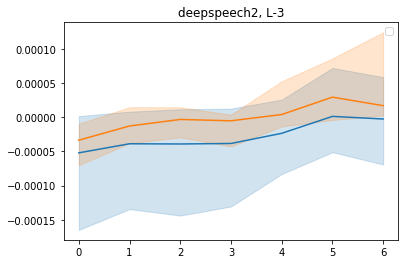

In [41]:
model_name = 'deepspeech2'
layer_id = 3
sig_betas_mean = visualize_parameters(model_name, layer_id, sig_sess_channels)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Peak corr (median): 6.179806594363675e-05, occurs at x_coordinate: 0
Peak corr (max): 0.001798918255172022, occurs at x_coordinate: 0
Peak corr (median): 4.891026118243709e-05, occurs at x_coordinate: 0
Peak corr (max): 0.00037077921681518517, occurs at x_coordinate: 0


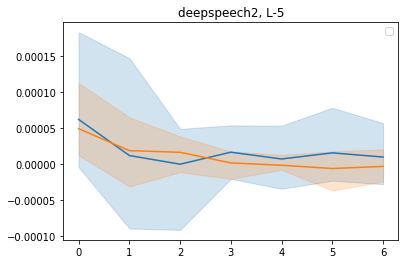

In [42]:
model_name = 'deepspeech2'
layer_id = 5
sig_betas_mean = visualize_parameters(model_name, layer_id, sig_sess_channels)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Peak corr (median): 3.622482112684851e-05, occurs at x_coordinate: 0
Peak corr (max): 0.0008214477948906428, occurs at x_coordinate: 6
Peak corr (median): 2.4404669983513955e-05, occurs at x_coordinate: 0
Peak corr (max): 0.00011764960776529259, occurs at x_coordinate: 6


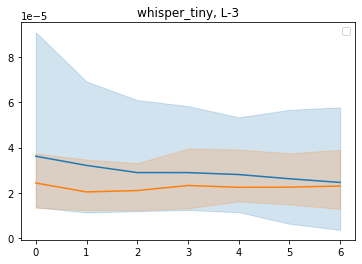

In [44]:
model_name = 'whisper_tiny'
layer_id = 3
sig_betas_mean = visualize_parameters(model_name, layer_id, sig_sess_channels)

In [46]:
sig_betas_mean['core'].shape

(7, 220)

In [47]:
sig_betas_mean['non-primary'].shape

(7, 33)

In [16]:
betas[2][:,:,32].mean(axis=0)


array([ 0.00073723, -0.00035431, -0.00079245, -0.00019991,  0.00055252,
        0.00052767, -0.00037049])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Peak corr (median): 4.405349759439298e-05, occurs at x_coordinate: 4
Peak corr (max): 0.0011318471693544006, occurs at x_coordinate: 6
Peak corr (median): 1.5375583542426458e-05, occurs at x_coordinate: 5
Peak corr (max): 0.00012921619109922887, occurs at x_coordinate: 6


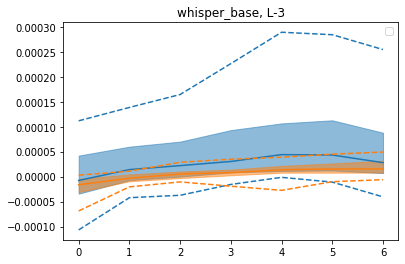

In [34]:
model_name = 'whisper_base'
layer_id = 3
sig_betas_mean = visualize_parameters(model_name, layer_id, sig_sess_channels)

/tmp/ipykernel_42083/2814524410.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(-1*np.log(sig_betas_mean['core'][0]))


(array([ 3., 16., 38., 17.,  8.,  1.,  5.,  1.,  0.,  2.]),
 array([ 7.47331694,  8.35656566,  9.23981437, 10.12306309, 11.0063118 ,
        11.88956052, 12.77280924, 13.65605795, 14.53930667, 15.42255538,
        16.3058041 ]),
 <BarContainer object of 10 artists>)

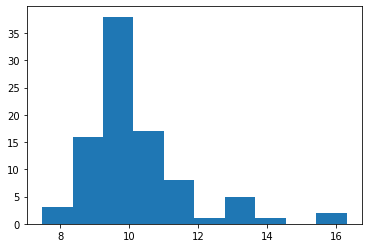

In [28]:
plt.hist(-1*np.log(sig_betas_mean['core'][0]))

/tmp/ipykernel_42083/3160269286.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(-1*np.log(sig_betas_mean['non-primary'][0]))


(array([1., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([11.26154934, 11.45047042, 11.63939151, 11.82831259, 12.01723368,
        12.20615476, 12.39507585, 12.58399693, 12.77291802, 12.9618391 ,
        13.15076018]),
 <BarContainer object of 10 artists>)

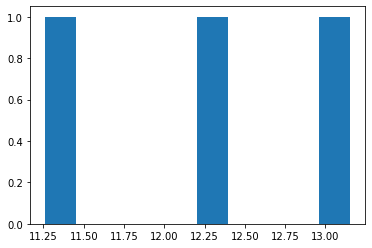

In [29]:
plt.hist(-1*np.log(sig_betas_mean['non-primary'][0]))

Applying threshold: 0.073 on column: 'normalizer'...
Applying threshold: 0.073 on column: 'normalizer'...


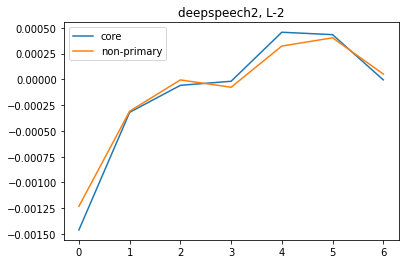

In [63]:
model_name = 'deepspeech2'
layer_id = 2
visualize_parameters(model_name, layer_id)

In [ ]:
model_name = 'deepspeech2'
layer_id = 2
visualize_parameters(model_name, layer_id)

In [54]:
sig_betas_mean['non-primary'].shape

(512, 7, 33)

In [ ]:
np.mean(sig_betas, axis=-1)

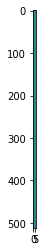

In [43]:
plt.imshow(sig_betas_mean)

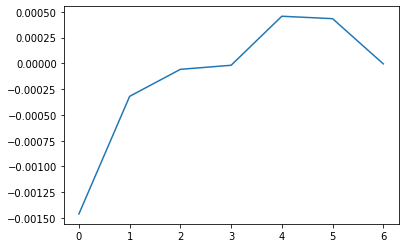

In [23]:
model_name = 'whisper_base'
shuffled = False
bin_width = 50
session = 200206
layer_id = 2

betas = io.read_trf_parameters(model_name, session, bin_width, shuffled)

Reading from file: /scratch/gilbreth/ahmedb/cache/trf/whisper_base/whisper_base_sess_200206_trf_50ms.pkl


In [26]:

betas[layer_id].shape

(512, 7, 64)

In [33]:
.shape

(512, 7, 63)

In [39]:
peak_layer_areas['core'].shape

(220,)

In [40]:
corr_dist_areas['core'].shape

(7, 220)

In [41]:
ch_dist = corr_dist_areas['core'][:, 32]

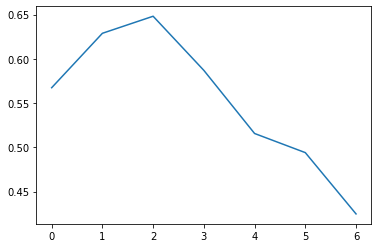

In [43]:
plt.plot(ch_dist)

In [51]:
ch_dist.shape
all_layers = np.ones(ch_dist.size)

In [52]:
all_layers

array([1., 1., 1., 1., 1., 1., 1.])

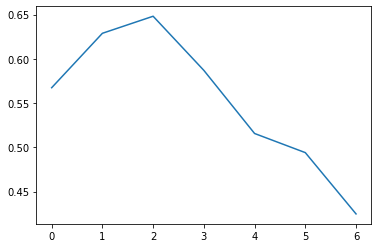

In [54]:
plt.plot(ch_dist)

In [55]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
    return exp_x / exp_x.sum()
	

In [57]:
out = softmax(ch_dist)

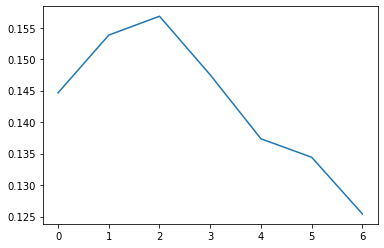

In [58]:
plt.plot(out)

In [ ]:
weighted_scores = all_layers*ch_dist

In [49]:
layer_preference = (all_layers*ch_dist).sum()/ch_dist.sum()

In [50]:
layer_preference

2.7852522915424447

In [ ]:
np.average()

#### rest...

In [3]:
from auditory_cortex.dataloader import DataLoader

dataloader = DataLoader()

Using default normalizer file...


Text(0.5, 1.0, 'mVocs trial durations (sec), total=299.47 \n min= 0.37, median= 0.76, max= 3.47')

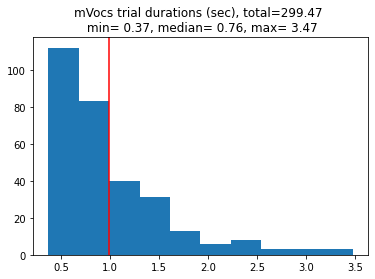

In [9]:
mVocs = True
stim_ids = np.arange(1, 303)
if mVocs:
	stimulus = 'mVocs'
else:
	stimulus = 'timit'
tr_durations = []
for stim in stim_ids:
	tr_id = dataloader.metadata.get_mVoc_tr_id(stim)[0]
	tr_durations.append(dataloader.get_stim_dur(tr_id, mVocs=mVocs))

plt.hist(tr_durations)
plt.axvline(np.mean(tr_durations), color='r')
plt.title(f"mVocs trial durations (sec), total={np.sum(tr_durations):.2f} "+ \
	f"\n min= {np.min(tr_durations):.2f}, median= {np.median(tr_durations):.2f}, max= {np.max(tr_durations):.2f}")

In [5]:
len(tr_durations)

302

Text(0.5, 1.0, 'timit trial durations (sec), total=1022.09 \n min= 0.99, median= 2.11, max= 2.59')

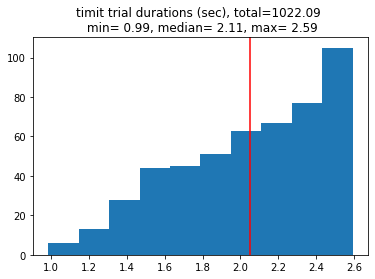

In [10]:

mVocs=False
if mVocs:
	stimulus = 'mVocs'
else:
	stimulus = 'timit'
	tr_durations = []
for tr in range(1, 500):
	tr_durations.append(dataloader.get_stim_dur(tr, mVocs=mVocs))
plt.hist(tr_durations)
plt.axvline(np.mean(tr_durations), color='r')
plt.title(f"{stimulus} trial durations (sec), total={np.sum(tr_durations):.2f} "+ \
	f"\n min= {np.min(tr_durations):.2f}, median= {np.median(tr_durations):.2f}, max= {np.max(tr_durations):.2f}")

In [25]:
np.min(tr_durations), np.max(tr_durations)

(0.985625, 2.592)

In [12]:
waveform = dataloader.get_stim_aud(12)

In [13]:
spect = nl.features.auditory_spectrogram(waveform, 48000, frame_len=10)

#### TRF reduces basedline, why?

##### STRF baseline...

In [31]:
corr_obj = STRFCorrelations('STRF_freqs80_wavlet'+'_'+'mVocs_trf_lags300_bw50_version_1')
select_data = corr_obj.data[
	(corr_obj.data['session']==200206) &\
	(corr_obj.data['mVocs_normalizer']>0.089)
	]
np.median(select_data['mVocs_test_cc_raw'])

Using default normalizer file...


0.2804940283612375

In [30]:
np.median(select_data['mVocs_normalized_test_cc'])

0.5306066616319665

In [11]:
corr_obj = STRFCorrelations('STRF_freqs80_wavlet'+'_'+'mVocs_trf_lags300_bw50_lmbda_norm')
select_data = corr_obj.data[
	(corr_obj.data['session']==200206) &\
	(corr_obj.data['mVocs_normalizer']>0.089)
	]
np.median(select_data['mVocs_test_cc_raw'])

Using default normalizer file...


0.2493997290542882

In [4]:
np.median(select_data['mVocs_normalized_test_cc'])

0.4731740905145806

In [13]:
# old results...
corr_obj = STRFCorrelations('STRF_freqs80_mVocs_wavlet_lags300')
select_data = corr_obj.data[
	(corr_obj.data['session']==200206) &\
	(corr_obj.data['mVocs_normalizer']>0.089)
	]
np.median(select_data['mVocs_test_cc_raw'])

Using default normalizer file...


0.2785068236448106

In [8]:
np.median(select_data['mVocs_normalized_test_cc'])

0.5396795456544174

##### untrained baseline...

In [35]:
corr_obj = Correlations('whisper_base'+'_'+'reset_timit_trf_lags300_bw50_version_1')
select_data = corr_obj.data[
	# (corr_obj.data['session']==200206) &\
	(corr_obj.data['layer']==2) &\
	(corr_obj.data['normalizer']>0.073)
	]
np.median(select_data['test_cc_raw'])

Using default normalizer file...


0.221591184474806

In [36]:
# median for all sessions....
np.median(select_data['normalized_test_cc'])

0.5264920025999433

In [32]:
corr_obj = Correlations('whisper_base'+'_'+'reset_timit_trf_lags300_lmbda')
select_data = corr_obj.data[
	(corr_obj.data['session']==200206) &\
	(corr_obj.data['layer']==2)# &\
	# (corr_obj.data['normalizer']>0.073
	# )
	]
np.median(select_data['test_cc_raw'])

Using default normalizer file...


0.3793650393078237

In [24]:
# median for all sessions....
np.median(select_data['normalized_test_cc'])

0.4961061613069233

In [52]:
corr_obj = STRFCorrelations('whisper_base'+'_'+'reset_timit')
select_data = corr_obj.data[
	(corr_obj.data['session']==200206) &\
	(corr_obj.data['layer']==2) #&\
	# (corr_obj.data['normalizer']>0.073)
	]
np.median(select_data['test_cc_raw'])

Using default normalizer file...


0.41553146055017953

In [34]:
# median for all sessions....
np.median(select_data['normalized_test_cc'])

0.5574135387208935

##### verifying modifications on TRF...

In [20]:
# dataset parameters...
session = 180420
bin_width = 50
model_name = 'whisper_base'
layer_ID = 2
mVocs = False
shuffled = True

# TRF grid search parameters...
lags = [299]
tmin = 0
delay=0
N_sents=500
num_workers=16
num_folds=3

# lags=[300]
use_nonlinearity=False
test_trial = None


In [21]:
dataset = DNNDataset(
	session, bin_width, model_name, layer_ID, mVocs=mVocs,
	shuffled=shuffled
	)
trf_obj = TRF(model_name, dataset)

180420: creating DNNDataset for timit data..
DNNDataset: Loading data for session-180420 at bin_width-50ms.
DataLoader: Extracting spikes for session-180420...
NeuralData:  Creating object for session: 180420 ... Done.
NeuralData: Reading neural spikes for 180420. 
Reading raw features from /scratch/gilbreth/ahmedb/cache/whisper_base/shuffled/whisper_base_raw_features.pkl
Resamping ANN features at bin-width: 50
TRF object created for 'whisper_base' model.


In [40]:
lags = [326]
tmin = 0
num_workers=16
num_folds=3

corr, opt_lag, opt_lmbda, trf_model = trf_obj.grid_search_CV(
	lags=lags, tmin=tmin,
	num_workers=num_workers, num_folds=num_folds,
	# use_nonlinearity=use_nonlinearity,
	# test_trial=test_trial
)


 Running for max lag=326 ms

 For fold=0: 
GpuTRF object created with alpha=1e-05, tmin=0.0, tmax=0.326, sfreq=20.0
GpuTRF object created with alpha=0.0001, tmin=0.0, tmax=0.326, sfreq=20.0
GpuTRF object created with alpha=0.001, tmin=0.0, tmax=0.326, sfreq=20.0
GpuTRF object created with alpha=0.01, tmin=0.0, tmax=0.326, sfreq=20.0
GpuTRF object created with alpha=0.1, tmin=0.0, tmax=0.326, sfreq=20.0
GpuTRF object created with alpha=1.0, tmin=0.0, tmax=0.326, sfreq=20.0
GpuTRF object created with alpha=10.0, tmin=0.0, tmax=0.326, sfreq=20.0
GpuTRF object created with alpha=100.0, tmin=0.0, tmax=0.326, sfreq=20.0
GpuTRF object created with alpha=1000.0, tmin=0.0, tmax=0.326, sfreq=20.0
GpuTRF object created with alpha=10000.0, tmin=0.0, tmax=0.326, sfreq=20.0
GpuTRF object created with alpha=100000.0, tmin=0.0, tmax=0.326, sfreq=20.0
GpuTRF object created with alpha=1000000.0, tmin=0.0, tmax=0.326, sfreq=20.0
GpuTRF object created with alpha=10000000.0, tmin=0.0, tmax=0.326, sfreq=20

In [41]:
predicted_num_bins = lags[0]/bin_width
print(f"{predicted_num_bins}, gives {np.round(predicted_num_bins)} so total bins={np.round(predicted_num_bins)+1}")


print(f"Actual shape: {trf_model.coef_[0].shape}")

6.52, gives 7.0 so total bins=8.0
Actual shape: (512, 8, 16)


In [39]:
lags = [326]
276 - 325
predicted_num_bins = lags[0]/bin_width
print(f"{predicted_num_bins}, gives {np.round(predicted_num_bins)} so total bins={np.round(predicted_num_bins)+1}")
# print(np.round(predicted_num_bins))

print(f"Actual shape: {trf_model.coef_[0].shape}")

6.52, gives 7.0 so total bins=8.0
Actual shape: (512, 7, 16)


In [ ]:
N_sents = 10
mapping_set = trf_obj.get_mapping_set_ids(N_sents)
print(f"Mapping set length: {len(mapping_set)}")

In [ ]:
mapping_set

In [7]:
trf_obj.coeff_

AttributeError: 'TRF' object has no attribute 'coeff_'

In [6]:
corr, opt_lag, opt_lmbda, trf_model = trf_obj.grid_search_CV(
		lags=lags, tmin=tmin,
		num_workers=num_workers, num_folds=num_folds,
		use_nonlinearity=use_nonlinearity,
		test_trial=test_trial
	)


 Running for max lag=300 ms

 For fold=0: 
GpuTRF object created with alpha=1e-05, tmin=0.0, tmax=0.3, sfreq=3.3333333333333335
GpuTRF object created with alpha=0.0001, tmin=0.0, tmax=0.3, sfreq=3.3333333333333335
GpuTRF object created with alpha=0.001, tmin=0.0, tmax=0.3, sfreq=3.3333333333333335
GpuTRF object created with alpha=0.01, tmin=0.0, tmax=0.3, sfreq=3.3333333333333335
GpuTRF object created with alpha=0.1, tmin=0.0, tmax=0.3, sfreq=3.3333333333333335
GpuTRF object created with alpha=1.0, tmin=0.0, tmax=0.3, sfreq=3.3333333333333335
GpuTRF object created with alpha=10.0, tmin=0.0, tmax=0.3, sfreq=3.3333333333333335
GpuTRF object created with alpha=100.0, tmin=0.0, tmax=0.3, sfreq=3.3333333333333335
GpuTRF object created with alpha=1000.0, tmin=0.0, tmax=0.3, sfreq=3.3333333333333335
GpuTRF object created with alpha=10000.0, tmin=0.0, tmax=0.3, sfreq=3.3333333333333335
GpuTRF object created with alpha=100000.0, tmin=0.0, tmax=0.3, sfreq=3.3333333333333335
GpuTRF object create

In [6]:
np.median(corr)

0.388147793401487

#### dataset object...

In [7]:
model_name = 'whisper_tiny'
session = 200206
bin_width = 50
layer_ID = 2
mVocs = True

dataset = DNNDataset(
	session, bin_width, model_name, layer_ID, mVocs=mVocs
	)

Using default normalizer file...
200206: creating DNNDataset for mVocs data..
NeuralData:  Creating object for session: 200206 ... Done.
DNNDataset: Loading data for session-200206 at bin_width-50ms.
DataLoader: Extracting spikes for session-200206...
NeuralData: Reading mVocs spikes for 200206. 
Reading raw features from /scratch/gilbreth/ahmedb/cache/mVocs/whisper_tiny/whisper_tiny_raw_features.pkl
Resamping ANN features at bin-width: 50


In [3]:
x,y = dataset.get_data()
# x = np.concatenate(x, axis=0)
# y = np.concatenate(y, axis=0)
# print(f"Training Data shape: {x.shape}, {y.shape}")
# x,y = dataset.get_test_data()
# x = np.concatenate(x, axis=0)
# print(f"Test Data shape: {x.shape}, {y.shape}")


In [8]:
tmin = 0
tmax = 0.3
bin_width = 50
sfreq = 1000/bin_width
opt_lmbda = 0.1
trf_model = GpuTRF(
					tmin, tmax, sfreq, alpha=opt_lmbda,
					# n_jobs=1, show_progress=True
					)


GpuTRF object created with alpha=0.1, tmin=0, tmax=0.3, sfreq=20.0


In [9]:
trf_model.fit(X=x, y=y)

GpuTRF(alpha=0.1, sfreq=20.0, tmax=0.3, tmin=0)

In [10]:
trf_model.coef_.shape

(384, 7, 64)

In [6]:
test_x, test_y = dataset.get_test_data()

In [7]:
pred_x = trf_model.predict(test_x)

In [8]:
pred_x.shape

(231, 64)

In [2]:
session = 200206
bin_width = 50
mVocs = True

dataset = BaselineDataset(
	session, bin_width, mVocs=mVocs, mel_spectrogram=True
	)

Using default normalizer file...
200206: creating DNNDataset for mVocs data..
NeuralData:  Creating object for session: 200206 ... Done.
Using mel-spectrogram for STRF.
DNNDataset: Loading data for session-200206 at bin_width-50ms.
DataLoader: Extracting spikes for session-200206...
NeuralData: Reading mVocs spikes for 200206. 


In [5]:
x,y = dataset.get_data()
x = np.concatenate(x, axis=0)
y = np.concatenate(y, axis=0)
print(f"Training Data shape: {x.shape}, {y.shape}")
x,y = dataset.get_test_data()
x = np.concatenate(x, axis=0)
print(f"Test Data shape: {x.shape}, {y.shape}")


Training Data shape: (14937, 80), (14937, 64)
Test Data shape: (231, 80), (15, 231, 64)


In [3]:
dataset.data_cache['features'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 49, 50, 52, 53, 54, 55, 56, 57, 59, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 74, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 97, 99, 100, 102, 105, 106, 107, 108, 109, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 133, 134, 135, 136, 137, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 165, 166, 167, 168, 169, 171, 172, 174, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 207, 208, 210, 211, 212, 213, 214, 216, 217, 218, 219, 221, 223, 224, 226, 227, 228, 229, 232, 233, 234, 236, 237, 238, 239, 240, 241, 243, 244, 245, 246, 247, 248, 249, 251, 252, 253, 255, 256, 257, 258, 259, 261, 264, 265, 266, 267, 268, 269, 270, 271, 272, 27

In [4]:
testing_stim_ids = dataset.get_testing_stim_ids(mVocs=dataset.mVocs)

In [5]:
testing_stim_ids

[7, 9, 12, 15, 24, 29, 30, 33, 44, 45, 48]

In [6]:
stim = 7

In [7]:
repeated_spikes = dataset.dataloader.get_neural_data_for_repeated_trials(
                session=dataset.session,
                bin_width=dataset.bin_width,
                delay=0,
                stim_ids=[stim],
                mVocs=dataset.mVocs
                )
repeated_spikes.shape

(15, 16, 64)

In [8]:
tr_id = dataset.dataloader.metadata.get_mVoc_tr_id(stim)[0]
# features_list.append(features[tr_id])

In [9]:
tr_id

6

In [ ]:
# x,y = dataset.get_data()
# x = np.concatenate(x, axis=0)
# y = np.concatenate(y, axis=0)
# print(x.shape, y.shape)

#### comparing gpu accelerated model with naplib

In [2]:
model_name = 'whisper_tiny'
session = 200206
bin_width = 50
layer_ID = 2
mVocs = True

tmax=300
tmin=0 
num_folds = 3

num_workers=1
num_folds=3

lags=None
use_nonlinearity=False
test_trial = None

In [3]:
dataset = DNNDataset(
	session, bin_width, model_name, layer_ID, mVocs=mVocs
	)
# trf_obj = TRF(model_name, dataset)

# corr, opt_lag, opt_lmbda = trf_obj.grid_search_CV(
# 		lags=lags, tmin=tmin,
# 		num_workers=num_workers, num_folds=num_folds,
# 		use_nonlinearity=use_nonlinearity,
# 		test_trial=test_trial
# 	)

Using default normalizer file...
200206: creating DNNDataset for mVocs data..
NeuralData:  Creating object for session: 200206 ... Done.
DNNDataset: Loading data for session-200206 at bin_width-50ms.
DataLoader: Extracting spikes for session-200206...
NeuralData: Reading mVocs spikes for 200206. 
Reading raw features from /scratch/gilbreth/ahmedb/cache/mVocs/whisper_tiny/whisper_tiny_raw_features.pkl
Resamping ANN features at bin-width: 50


In [8]:
training_stim_ids, all_trial_ids = dataset.get_training_stim_ids(mVocs=dataset.mVocs)
# mapping_x, mapping_y = dataset.get_data()

In [10]:
train_x, train_y = dataset.get_data(training_stim_ids[:400])
val_x, val_y = dataset.get_data(training_stim_ids[400:])

In [26]:
tmax

0.0003

In [27]:
from auditory_cortex.computational_models.encoding import GpuTRF
tmax = 0.3
sfreq = 1000/dataset.bin_width

trf_model = GpuTRF(
					tmin, tmax, sfreq, 
					alpha=2
					# n_jobs=1, show_progress=True
					)

GpuTRF object created with alpha=2, tmin=0, tmax=0.3, sfreq=20.0
LinearModel object created with alpha=2


In [12]:
X = val_x

In [19]:
X.shape

(5263, 384)

In [ ]:
X = np.concatenate(X, axis=-2) 	

In [28]:


# Delay inputs and reshape
if X.ndim == 3:
	# if there is layer axis in X, then we need to delay each layer separately
	# self.n_models = X.shape[0]
	X_delayed = []
	for i in range(X.shape[0]):
		x_tmp, _ = trf_model._delay_and_reshape(X[i])
		X_delayed.append(x_tmp)
	X_delayed = np.concatenate(X_delayed, axis=0)
else:
	X_delayed, _ = trf_model._delay_and_reshape(X)

In [29]:
X_delayed.shape

(5263, 2688)

In [30]:
test_x, test_y = dataset.get_test_data()

In [34]:
test_y.shape

(15, 231, 64)

In [31]:
X = np.concatenate(test_x, axis=-2) 	

In [35]:
X.shape

(231, 384)

In [36]:
X_delayed, _ = trf_model._delay_and_reshape(X)

In [37]:
X_delayed.shape

(231, 2688)

In [5]:
sfreq = 1000/bin_width
tmax = tmax/1000 # convert seconds to ms
opt_lmbda = 2

In [6]:
from auditory_cortex.computational_models.encoding import GpuTRF
trf_model = GpuTRF(
					tmin, tmax, sfreq, 
					alpha=opt_lmbda
					# n_jobs=1, show_progress=True
					)
# 

GpuTRF object created with alpha=2, tmin=0, tmax=0.3, sfreq=20.0
LinearModel object created with alpha=2


: 

In [7]:
trf_model.fit(X=mapping_x, y=mapping_y)

Calling fit() method of GpuTRF


Calling fit() method of LinearModel


GpuTRF(alpha=2, sfreq=20.0, tmax=0.3, tmin=0)

In [11]:
trf_model.coef_.shape

(384, 7, 64)

: 

In [ ]:
cross_validted_fit(
			self,
			tmax=50,
			tmin=0, 
			num_folds=3,
			num_workers=1,
			use_nonlinearity=False,
		)

#### gpu accelerated linear model..

In [4]:
model_name = 'whisper_tiny'
session = 200206
bin_width = 50
layer_ID = 2
mVocs = True

: 

In [5]:

dataset_obj = DNNDataset(
				session, bin_width, model_name, layer_ID, mVocs=mVocs
				)


tmax=300
tmin=0 
num_folds = 3

# function starts here...
tmin = tmin/1000
tmax = tmax/1000
sfreq = 1000/dataset_obj.bin_width
num_channels = dataset_obj.num_channels

# Deprecated...
mapping_set = dataset_obj.training_sent_ids

lmbdas = np.logspace(-2, 12, 15)
lmbda_score = np.zeros(((len(lmbdas), num_channels)))
np.random.shuffle(mapping_set)
size_of_chunk = int(len(mapping_set) / num_folds)

r = 0
print(f"\n For fold={r}: ")
if r<(num_folds-1):
	val_set = mapping_set[r*size_of_chunk:(r+1)*size_of_chunk]
else:
	val_set = mapping_set[r*size_of_chunk:]
train_set = mapping_set[np.isin(mapping_set, val_set, invert=True)]

train_x, train_y = dataset_obj.get_data(stim_ids=train_set)
val_x, val_y = dataset_obj.get_data(stim_ids=val_set)



# # tempp
# val_y = [val[:,:2] for val in val_y]
# i = 0 
# lmbda = lmbdas[i]


Using default normalizer file...
200206: creating DNNDataset for mVocs data..
NeuralData:  Creating object for session: 200206 ... Done.
DNNDataset: Loading data for session-200206 at bin_width-50ms.
DataLoader: Extracting spikes for session-200206...
NeuralData: Reading mVocs spikes for 200206. 
Reading raw features from /scratch/gilbreth/ahmedb/cache/mVocs/whisper_tiny/whisper_tiny_raw_features.pkl


: 

: 

#### starts from here...

In [ ]:
from auditory_cortex.computational_models.encoding import GpuTRF
trf_model = GpuTRF(
					tmin, tmax, sfreq, 
					alpha=opt_lmbda
					# n_jobs=1, show_progress=True
					)

In [128]:
# from auditory_cortex.computational_models.encoding import GpuTRF
from sklearn.linear_model import RidgeCV, ElasticNet, Ridge, PoissonRegressor
estimator = Ridge(alpha=2)
trf_model = GpuTRF(
	tmin, tmax, sfreq, #estimator=estimator,
						n_jobs=1, show_progress=True
)
# trf_model = nl.encoding.TRF(
# 	tmin, tmax, sfreq, #estimator=estimator,
#                         n_jobs=1, show_progress=True
# )

In [135]:
train_x = [x[None,...] for x in train_x]
# train_x = [x.squeeze() for x in train_x]

In [136]:
print(f"x.shape: {train_x[0].shape}")
print(f"y.shape: {train_y[0].shape}")
out = trf_model.fit(X=train_x, y=train_y)

x.shape: (1, 13, 384)
y.shape: (13, 64)
None
X shape: (1, 9969, 384)
y shape: (9969, 64)
X shape: (9969, 2688)
y shape: (9969, 64)


In [ ]:
for xx, yy in zip(X, y):
			X_tmp, y_tmp = self._delay_and_reshape(xx, yy)

In [35]:
trf_model = nl.encoding.TRF(
						tmin, tmax, sfreq, #estimator=estimator,
						n_jobs=1, show_progress=True
						)